### Conexión a la BD de RDS

In [408]:
type(sample)

list

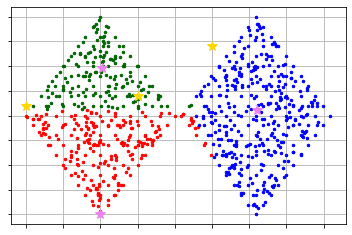

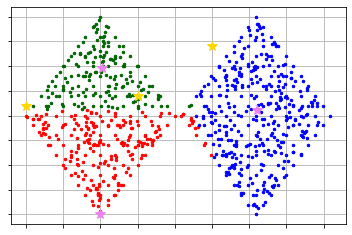

In [387]:
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)
# Create instance of K-Medians algorithm.
initial_medians = [[0.0, 0.1], [2.5, 0.7], [1.5, 0.2]]
kmedians_instance = kmedians(sample, initial_medians)
# Run cluster analysis and obtain results.
kmedians_instance.process()
clusters = kmedians_instance.get_clusters()
medians = kmedians_instance.process()
# Visualize clustering results.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(initial_medians, marker='*', markersize=10)
visualizer.append_cluster(medians, marker='*', markersize=10)
visualizer.show()

In [3]:
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES

import datetime
import missingno as msno
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from xgboost import XGBRegressor,XGBClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings("ignore")
from sqlalchemy import create_engine, text
import scipy.stats as stats
#maximum number of rows to display
pd.options.display.max_rows = 20
import time
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import plotly.express as px

DB_USERNAME = 'damjimenezgu'
DB_PASSWORD = 'Analista1!' 
DB_ENDPOINT = 'ds4a-demo-instance.cqjr4hyu9xaq.us-east-1.rds.amazonaws.com' 
DB_NAME = 'desertion_pj_team67' 

engine=create_engine(f'postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_ENDPOINT}/{DB_NAME}', max_overflow=20)

def runQuery(sql):
    result = engine.connect().execution_options(isolation_level="AUTOCOMMIT").execute((text(sql)))
    return pd.DataFrame(result.fetchall(), columns=result.keys())

### Pasar datos de RDS a pandas dataframe

In [4]:
start_time = time.time()

aux=runQuery("""select * from master_table_by_municipio limit 1;""")
all_vars=aux.columns
keep_vars_2016=['icbf_cobert_inmu_dtp_hep_1','icbf_cobert_inmu_tv_1','icbf_cobert_vacu_bcg_nac_v','icbf_cobert_vacu_fib_ama_1','icbf_cobert_vacu_haem_b_1','icbf_cobert_vacu_neumco_1','icbf_cobert_vacu_polio_1','icbf_cobert_vacu_rotav_1','icbf_num_afi_reg_contr_18','icbf_num_afi_reg_subs_18','icbf_num_nin_adol_desvinc','icbf_raz_mort_mater_x100m_nac_viv','icbf_tasa_fecun_nin_10_14','icbf_tasa_fecun_nin_15_19','icbf_tasa_mort_1_1000_nac_v','icbf_tasa_mort_fetal','icbf_tasa_mort_desnut_5','icbf_tasa_mort_eda_5','icbf_tasa_mort_era_5']
keep_vars_2017=['me_tamano_promedio_de_grupo','me_sedes_conectadas_a_internet']
keep_vars_2018=['pib_valor_agregado','pobr_ipm','pobr_imp_cabecera','pobr_ipm_cen_pobl']

vars_remove=keep_vars_2016+keep_vars_2017+keep_vars_2018
keep_vars_1=all_vars.drop(vars_remove)
keep_vars_1='A.'+',A.'.join(keep_vars_1)
keep_vars_2='B.'+',B.'.join(keep_vars_2016)
keep_vars_3='C.'+',C.'.join(keep_vars_2017)
keep_vars_4='D.'+',D.'.join(keep_vars_2018)


mun = runQuery("""
select """+keep_vars_1+""","""+keep_vars_2+""","""+keep_vars_3+""","""+keep_vars_4+""" from master_table_by_municipio A 
LEFT JOIN (select * from master_table_by_municipio where year_cohort = 2016 and desertion_perc is not null) B
on A.code_municip= B.code_municip
LEFT JOIN (select * from master_table_by_municipio where year_cohort = 2017 and desertion_perc is not null) C
on A.code_municip= C.code_municip
LEFT JOIN (select * from master_table_by_municipio where year_cohort = 2018 and desertion_perc is not null) D
on A.code_municip= D.code_municip
where A.year_cohort = 2019 and A.desertion_perc is not null;""")

vars_convert=['dane_alu_01','dane_alu_02','dane_alu_04','dane_alu_05','dane_alu_06','dane_alu_07','dane_alu_08','dane_alu_09','dane_alu_10','dane_alu_11','dane_alu_12','dane_alu_13','dane_alu_14','dane_alu_15','dane_alu_16','dane_alu_17','dane_alu_18','dane_alu_19','dane_alu_20','dane_alu_21','dane_alu_22','dane_alu_23','dane_alu_24','dane_alu_25','dane_doc_01','dane_doc_02','dane_doc_03','dane_doc_04','dane_doc_05','dane_doc_06','dane_doc_07','dane_doc_08','dane_doc_09','dane_doc_10','dane_doc_11','dane_doc_12','dane_doc_13','dane_doc_14','dane_doc_15','dane_doc_16','dane_doc_17','dane_doc_18','dane_doc_19','dane_doc_20','dane_doc_21','dane_doc_22','dane_doc_23','dane_doc_24','dane_doc_25','dane_doc_26','dane_doc_27']

for col in vars_convert:
        mun[col] = mun[col].astype(np.float64)
        
print("Ejecución: %s seconds" % (time.time() - start_time))

Ejecución: 11.323750495910645 seconds


 ### Revisar datos faltantes

Ejecución: 1.603668451309204 seconds


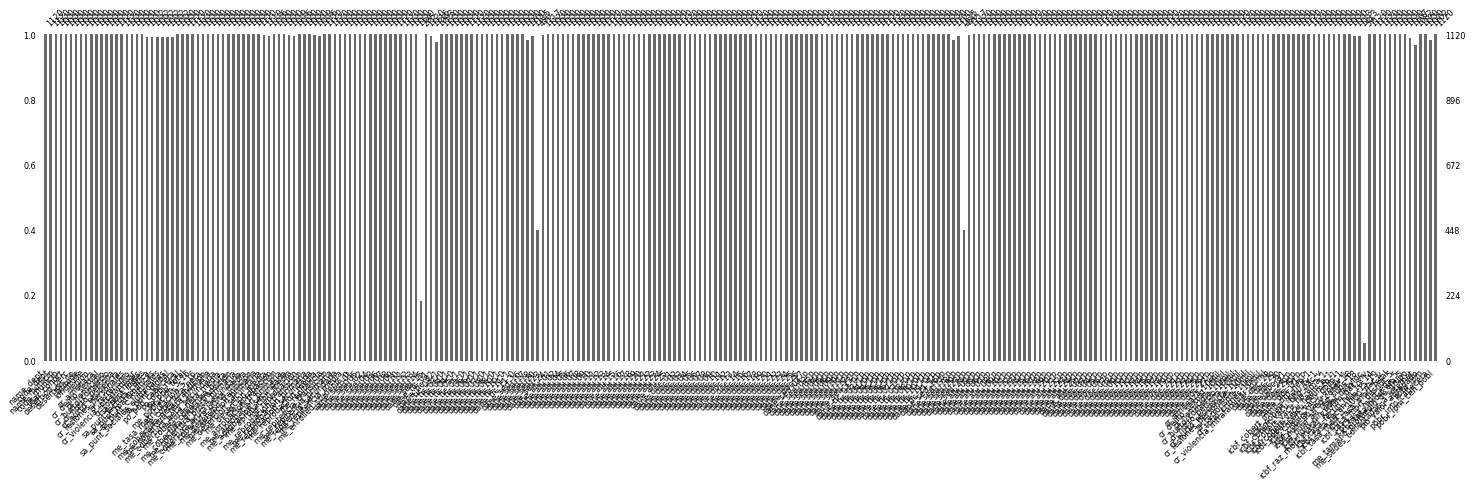

In [154]:
start_time = time.time()
msno.bar(mun, labels=True, figsize=(25,6), fontsize=8)
print("Ejecución: %s seconds" % (time.time() - start_time))

In [6]:
def full_describe(dataframe,variables="all",variabilidad=20,completitud=10): #summary, univariado, describe, analisis descriptivo, describir, analisis exploratorio
    #Descripcion de los parametros:
    #dataframe: Tabla a usar en formato DataFrame
    #variables: variables sobre las que se va a calcular el describe. Formas posibles: "all", ingresar secuencia (ie. '1:8'), 
    #ingresar lista de numeros o de nombres de variables (ie. '1,4,9' o 'var1,var2,var3')
    #completitud: Minimo de completitud aceptada por variable (valor entre 0 y 100)
    #variabilidad: Minimo de variabilidad aceptada por variable (0,2,10,20,50,100)
    print("Inicia calculo del describe, Hora: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    start1 = datetime.datetime.now()
    if variables == "all": #Si se desea analisis para todas las variables
        #Calcular describe y adicionar (concatenar) filas con Missing
        resumen=pd.concat([dataframe.describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.isnull().sum().to_frame(name = 'missing').T],sort=False)
    elif ":" in variables: #Si se desea analisis para secuencia de variables n1:n2
        #Calcular describe y adicionar (concatenar) filas con Missing
        variables_serie=list(pd.to_numeric((variables).split(':')))
        variables_serie=list(pd.Series(range(variables_serie[0],variables_serie[1])))
        resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
    else:
        try: #Si se desea analisis para array numerico (posiciones) de variables [n1,n2,n3,...]
            # Dividir valor de variables por coma, creando lista numerica
            variables_serie=list(pd.to_numeric((variables).split(',')))
            #Calcular describe y adicionar (concatenar) filas con Missing
            resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
        except: 
            if set(list(variables.split(","))).issubset(list(dataframe.columns)): #Si se desea analisis para array string (nombres de campos) de variables ['nom1','nom2','nom3',...]
                # Dividir valor de variables por coma, creando lista de cadena de texto
                variables_serie=list(variables.split(","))
                #Calcular describe y adicionar (concatenar) filas con Missing
                resumen=pd.concat([dataframe.loc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.loc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
            else: #Garbage Collector para casos diferentes
                resumen="Invalid entry for variables"
                
    print("Finaliza calculo del describe. Tiempo transcurrido: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    
    start2 = datetime.datetime.now()
    print("Inicia calculo de completitud y variabilidad, Hora: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    if isinstance(resumen, pd.DataFrame)==True: #Verificar si existe algun error en los parametros ingresados
        #Calcular cantidad total
        resumen.loc['total count']=resumen.loc[['count','missing']].sum()
        #Calcular porcentaje de missing
        resumen.loc['% missing']=np.around((resumen.loc['missing']*100/resumen.loc['total count']).astype(np.double),4)
        #Trasponer para usar de mejor forma el codigo
        resumen=resumen.T
        #Calcular variabilidad
        resumen['variabilidad'] = np.where(resumen['min']==resumen['max'], '00_variacion', 
                                           np.where(resumen['1%']==resumen['99%'], '02_variacion', 
                                                   np.where(resumen['5%']==resumen['95%'], '10_variacion', 
                                                           np.where(resumen['10%']==resumen['90%'], '20_variacion', 
                                                                   np.where(resumen['25%']==resumen['75%'], '50_variacion', 
                                                                           'variabilidad_alta')))))
        if variabilidad == 0:
            resumen['decision_variabilidad'] = "aceptar"
        elif variabilidad == 2:
            resumen['decision_variabilidad'] = np.where(resumen['variabilidad']=='00_variacion', 'rechazar',
                                                        'aceptar')
        elif variabilidad == 10:
            resumen['decision_variabilidad'] = np.where((resumen['variabilidad']=='00_variacion') | (resumen['variabilidad']=='02_variacion'), 'rechazar',
                                                        'aceptar')
        elif variabilidad == 20:
            resumen['decision_variabilidad'] = np.where((resumen['variabilidad']=='00_variacion') | (resumen['variabilidad']=='02_variacion') | (resumen['variabilidad']=='10_variacion'), 'rechazar',
                                                        'aceptar')
        elif variabilidad == 50:
            resumen['decision_variabilidad'] = np.where((resumen['variabilidad']=='00_variacion') | (resumen['variabilidad']=='02_variacion') | (resumen['variabilidad']=='10_variacion') | (resumen['variabilidad']=='20_variacion'), 'rechazar',
                                                        'aceptar')
        elif variabilidad == 100: 
            resumen['decision_variabilidad'] = np.where((resumen['variabilidad']=='00_variacion') | (resumen['variabilidad']=='02_variacion') | (resumen['variabilidad']=='10_variacion') | (resumen['variabilidad']=='20_variacion') | (resumen['variabilidad']=='50_variacion'), 'rechazar',
                                                        'aceptar')
        else:
            resumen['decision_variabilidad']="VALOR NO VALIDO"
            print("Invalid entry for parameter variabilidad")
        #Calcular completitud
        resumen['decision_completitud']=np.where(resumen['% missing']==0,'aceptar_100',
                                                 np.where(resumen['% missing']>completitud, 'rechazar','aceptar')) 
    else:
        resumen="Invalid entry for variables"
        
    print("Finaliza calculo de completitud y variabilidad. Tiempo transcurrido: "+str((datetime.datetime.now() - start2).seconds)+" segs")
    
    
    print("Finaliza calculo del proceso completo. Tiempo transcurrido total: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    return resumen

In [7]:
#Invocar funcion
resumen=full_describe(dataframe=mun,variabilidad=20,completitud=30)
resumen.to_clipboard(index=True,header=True)

Inicia calculo del describe, Hora: 12:23:45
Finaliza calculo del describe. Tiempo transcurrido: 0 segs
Inicia calculo de completitud y variabilidad, Hora: 12:23:46
Finaliza calculo de completitud y variabilidad. Tiempo transcurrido: 0 segs
Finaliza calculo del proceso completo. Tiempo transcurrido total: 0 segs


### Rankear deserción usando DBScan

In [8]:
start_time = time.time()
vars_keep=['desertion_perc', 'desertion_no','me_cobertura_neta']
X=mun[vars_keep].copy()
X['desertion_no_log']=np.log(X['desertion_no'])
X['desertion_no_log']=X['desertion_no_log'].replace([np.inf, -np.inf], np.nan)
X['desertion_no_log']=X['desertion_no_log'].fillna(X['desertion_no_log'].min())

vars_keep_trans=['desertion_perc', 'desertion_no_log','me_cobertura_neta']
X_train=X[vars_keep_trans]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

dbscan = DBSCAN(eps=0.2, min_samples = 2)
clusters = pd.Series(dbscan.fit_predict(X_scaled))
print(clusters.value_counts())

X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = [sub + "_std" for sub in vars_keep_trans]
X=pd.concat([X,X_scaled],axis=1)
X = pd.concat([X, clusters], axis=1)
X = pd.concat([X, mun['name_municip']], axis=1)
X.rename(columns={0: "deser_perc_rank"},inplace=True)

fig = px.scatter(X, x="desertion_no_log", y="desertion_perc", color="deser_perc_rank",width=700,height =500,hover_name='name_municip')
fig.show()

fig = px.scatter(X, x="me_cobertura_neta", y="desertion_perc", color="deser_perc_rank",width=700,height =500,hover_name='name_municip')
fig.show()
print("Ejecución: %s seconds" % (time.time() - start_time))

-1     390
 0     314
 90     10
 73     10
 33      9
      ... 
 88      2
 92      2
 94      2
 95      2
 67      2
Length: 137, dtype: int64


Ejecución: 21.45328426361084 seconds


### Rankear deserción usando Kmeans

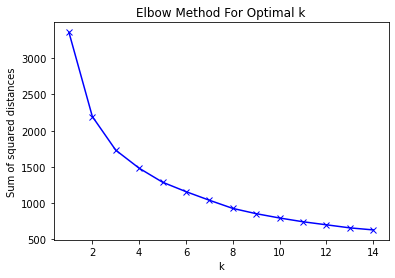

Ejecución: 5.044813632965088 seconds


In [9]:
start_time = time.time()

vars_keep=['desertion_perc', 'desertion_no','me_cobertura_neta']
X=mun[vars_keep].copy()
X['desertion_no_log']=np.log(X['desertion_no'])
X['desertion_no_log']=X['desertion_no_log'].replace([np.inf, -np.inf], np.nan)
X['desertion_no_log']=X['desertion_no_log'].fillna(X['desertion_no_log'].min())
vars_keep_trans=['desertion_perc', 'desertion_no_log','me_cobertura_neta']
X_train=X[vars_keep_trans]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
#X_scaled = X_train

#Número de clusters óptimo
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=12345)
    km = km.fit(X_scaled)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()
print("Ejecución: %s seconds" % (time.time() - start_time))

### Kmeans con 3 grupos y 3 variables

1_Alta     426
3_Baja     415
2_Media    279
Name: deser_perc_rank, dtype: int64
Inercia: 1730.9684344814393
Ejecución: 0.7924561500549316 seconds


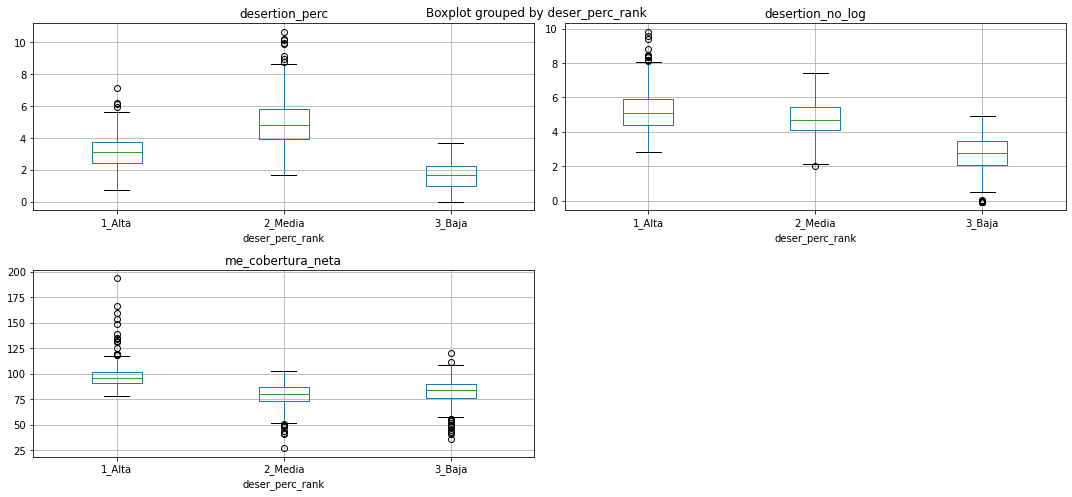

In [10]:
vars_keep=['desertion_perc', 'desertion_no','me_cobertura_neta']
X=mun[vars_keep].copy()
X['desertion_no_log']=np.log(X['desertion_no'])
X['desertion_no_log']=X['desertion_no_log'].replace([np.inf, -np.inf], np.nan)
X['desertion_no_log']=X['desertion_no_log'].fillna(X['desertion_no_log'].min())
vars_keep_trans=['desertion_perc', 'desertion_no_log','me_cobertura_neta']
X_train=X[vars_keep_trans]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
#X_scaled=X_train

start_time = time.time()
#Ajustar Kmeans con 3 grupos
km = KMeans(n_clusters=3, random_state=12345).fit(X_scaled)
clusters=pd.Series(km.labels_)


X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = [sub + "_std" for sub in vars_keep_trans]
X=pd.concat([X,X_scaled],axis=1)
X = pd.concat([X, clusters], axis=1)
X = pd.concat([X, mun['name_municip']], axis=1)
X.rename(columns={0: "deser_perc_rank"},inplace=True)

X['deser_perc_rank']=np.where(X['deser_perc_rank'] == 2, '3_Baja'
                                       , np.where(X['deser_perc_rank'] == 1, '1_Alta'
                                                  , np.where(X['deser_perc_rank'] == 0,'2_Media','0')))

bp_vars=vars_keep_trans+['deser_perc_rank']
fig, axes = plt.subplots(2,2,figsize=(15,7)) # create figure and axes

for i,el in enumerate(list(X[bp_vars].columns.values)[:-1]):
    a = X[bp_vars].boxplot(el, by="deser_perc_rank", ax=axes.flatten()[i])

fig.delaxes(axes[1,1]) # remove empty subplot
plt.tight_layout() 

print(X['deser_perc_rank'].value_counts())
print("Inercia: "+str(km.inertia_))
print("Ejecución: %s seconds" % (time.time() - start_time))

### Kmeans con 4 grupos y 2 variables

1_DS_Alta-CB_Baja    366
3_DS_Baja-CB_Alta    349
4_DS_Alta-CB_Alta    339
2_DS_Baja-CB_Baja     66
Name: deser_perc_rank, dtype: int64
Inercia: 894.3524009666921


Ejecución: 0.8698844909667969 seconds


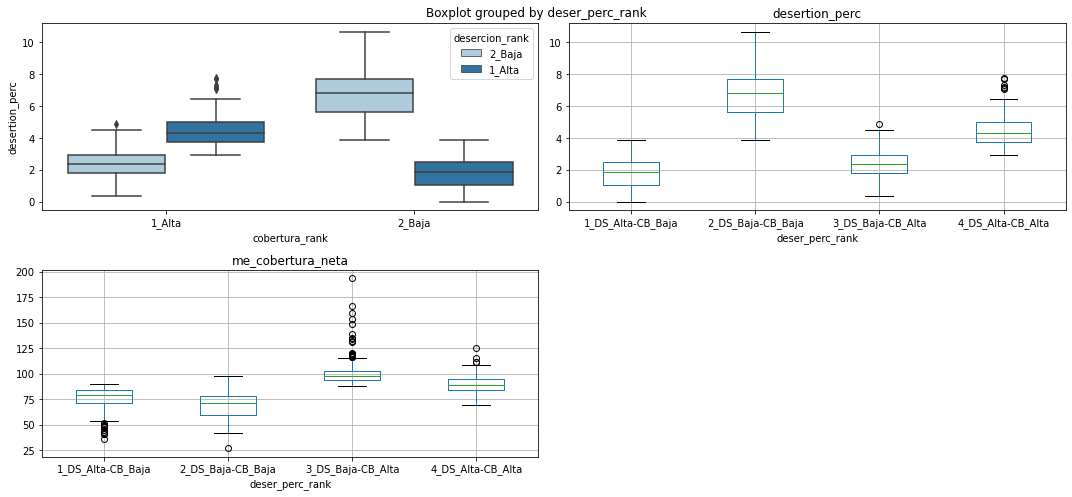

In [11]:
vars_keep=['desertion_perc', 'me_cobertura_neta']
X=mun[vars_keep].copy()
vars_keep_trans=['desertion_perc', 'me_cobertura_neta']
X_train=X[vars_keep_trans]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
#X_scaled=X_train

start_time = time.time()
#Ajustar Kmeans con 4 grupos
km = KMeans(n_clusters=4, random_state=12345).fit(X_scaled)
clusters=pd.Series(km.labels_)

X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = [sub + "_std" for sub in vars_keep_trans]
X=pd.concat([X,X_scaled],axis=1)
X = pd.concat([X, clusters], axis=1)
X = pd.concat([X, mun['name_municip']], axis=1)
X.rename(columns={0: "deser_perc_rank"},inplace=True)

X['deser_perc_rank']=np.where(X['deser_perc_rank'] == 1, '1_DS_Alta-CB_Baja'
                                       , np.where(X['deser_perc_rank'] == 2, '3_DS_Baja-CB_Alta'
                                                  , np.where(X['deser_perc_rank'] == 0, '2_DS_Baja-CB_Baja'
                                                             , np.where(X['deser_perc_rank'] == 3, '4_DS_Alta-CB_Alta',''))))

X['cobertura_rank']=np.where(X['deser_perc_rank'].str.slice(10,17).isin(['CB_Baja']),'2_Baja','1_Alta')
X['desercion_rank']=np.where(X['deser_perc_rank'].str.slice(2,9).isin(['DS_Baja']),'2_Baja','1_Alta')

bp_vars=vars_keep_trans+['deser_perc_rank']
fig, axes = plt.subplots(2,2,figsize=(15,7)) # create figure and axes
ax = sns.boxplot(x="cobertura_rank", y="desertion_perc", hue="desercion_rank",data=X, palette="Paired",ax=axes.flatten()[0])
for i,el in enumerate(list(X[bp_vars].columns.values)[:-1]):
    a = X[bp_vars].boxplot(el, by="deser_perc_rank", ax=axes.flatten()[i+1])

fig.delaxes(axes[1,1]) # remove empty subplot


plt.tight_layout() 

print(X['deser_perc_rank'].value_counts())
print("Inercia: "+str(km.inertia_))
fig = px.scatter(X, x="me_cobertura_neta", y="desertion_perc", color="deser_perc_rank",width=700,height =500,hover_name='name_municip')
fig.show()
print("Ejecución: %s seconds" % (time.time() - start_time))

### Kmeans con 4 grupos y 3 variables

Ejecución: 0.5984570980072021 seconds
2_DS_Baja-CB_Alta    357
1_DS_Baja-CB_Baja    269
4_DS_Alta-CB_Alta    255
3_DS_Alta-CB_Baja    239
Name: deser_perc_rank, dtype: int64
Inercia: 1481.745142384703


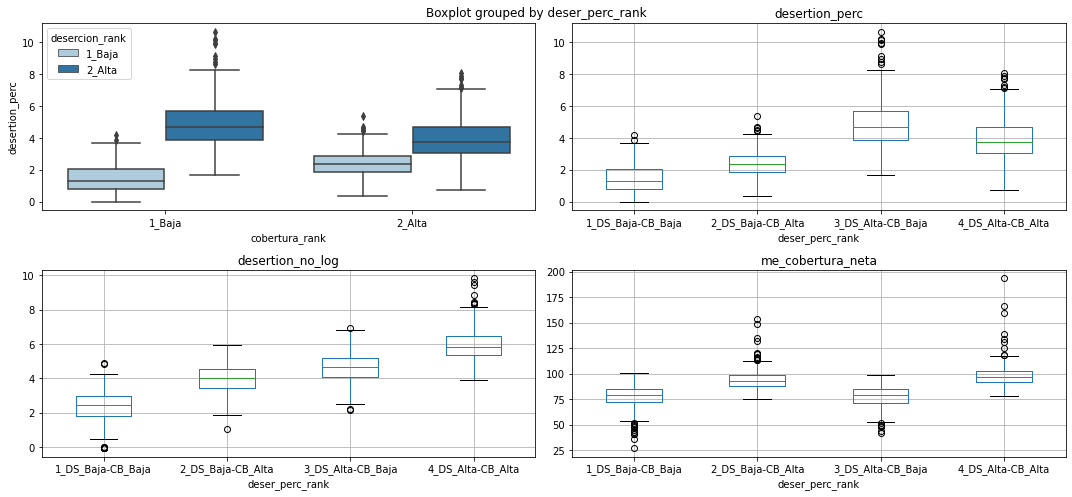

In [12]:
#Ajustar Kmeans con 4 grupos y 3 variables
vars_keep=['desertion_perc', 'desertion_no','me_cobertura_neta']
X=mun[vars_keep].copy()
X['desertion_no_log']=np.log(X['desertion_no'])
X['desertion_no_log']=X['desertion_no_log'].replace([np.inf, -np.inf], np.nan)
X['desertion_no_log']=X['desertion_no_log'].fillna(X['desertion_no_log'].min())
vars_keep_trans=['desertion_perc', 'desertion_no_log','me_cobertura_neta']
X_train=X[vars_keep_trans]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
#X_scaled=X_train

start_time = time.time()
#Ajustar Kmeans con 4 grupos
km = KMeans(n_clusters=4, random_state=12345).fit(X_scaled)
clusters=pd.Series(km.labels_)

X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = [sub + "_std" for sub in vars_keep_trans]
X=pd.concat([X,X_scaled],axis=1)
X = pd.concat([X, clusters], axis=1)
X = pd.concat([X, mun['name_municip']], axis=1)
X.rename(columns={0: "deser_perc_rank_aux"},inplace=True)

ranks=X.groupby(['deser_perc_rank_aux'])['desertion_perc','me_cobertura_neta'].mean().reset_index()
ranks=ranks.sort_values(by=['desertion_perc'])
ranks.index = [0,1,2,3]
ranks['des_flag']=[0,0,1,1]
ranks=ranks.sort_values(by=['me_cobertura_neta'])
ranks.index = [0,1,2,3]
ranks['cob_flag']=[0,0,1,1]

def flag_df(df):

    if (df['des_flag'] == 0) and (df['cob_flag'] == 0):
        return '1_DS_Baja-CB_Baja'
    elif (df['des_flag'] == 0) and (df['cob_flag'] == 1):
        return '2_DS_Baja-CB_Alta'
    elif (df['des_flag'] == 1) and (df['cob_flag'] == 0):
        return '3_DS_Alta-CB_Baja'
    elif (df['des_flag'] == 1) and (df['cob_flag'] == 1):
        return '4_DS_Alta-CB_Alta'

ranks['deser_perc_rank'] = ranks.apply(flag_df, axis = 1)

X=pd.merge(left=X, right=ranks, left_on='deser_perc_rank_aux', right_on='deser_perc_rank_aux')
X=X.drop(['desertion_perc_y', 'me_cobertura_neta_y', 'des_flag', 'cob_flag','deser_perc_rank_aux'], axis=1)
X.rename(columns = {'desertion_perc_x':'desertion_perc','me_cobertura_neta_x':'me_cobertura_neta'}, inplace = True) 

X['cobertura_rank']=np.where(X['deser_perc_rank'].str.slice(10,17).isin(['CB_Baja']),'1_Baja','2_Alta')
X['desercion_rank']=np.where(X['deser_perc_rank'].str.slice(2,9).isin(['DS_Baja']),'1_Baja','2_Alta')

bp_vars=vars_keep_trans+['deser_perc_rank']
fig, axes = plt.subplots(2,2,figsize=(15,7)) # create figure and axes

ax = sns.boxplot(x="cobertura_rank", y="desertion_perc", hue="desercion_rank",data=X, palette="Paired",ax=axes.flatten()[0])
for i,el in enumerate(list(X[bp_vars].columns.values)[:-1]):
    a = X[bp_vars].boxplot(el, by="deser_perc_rank", ax=axes.flatten()[i+1])

#fig.delaxes(axes[1,1]) # remove empty subplot


plt.tight_layout() 


print("Ejecución: %s seconds" % (time.time() - start_time))

print(X['deser_perc_rank'].value_counts())
print("Inercia: "+str(km.inertia_))

fig = px.scatter(X, x="desertion_no_log", y="desertion_perc", color="deser_perc_rank",width=700,height =500,hover_name='name_municip')
fig.show()

fig = px.scatter(X, x="me_cobertura_neta", y="desertion_perc", color="deser_perc_rank",width=700,height =500,hover_name='name_municip')
fig.show()


In [17]:
#stats.f_oneway(mun['desertion_perc'][mun['deser_perc_rank'] == '1_DS_Baja-CB_Baja'],
#               mun['desertion_perc'][mun['deser_perc_rank'] == '2_DS_Baja-CB_Alta'],
#               mun['desertion_perc'][mun['deser_perc_rank'] == '3_DS_Alta-CB_Baja'],
#               mun['desertion_perc'][mun['deser_perc_rank'] == '4_DS_Alta-CB_Alta'])


In [23]:
mun['deser_perc_rank']=X['deser_perc_rank']
mun['cobertura_rank']=X['cobertura_rank']
mun['desercion_rank']=X['desercion_rank']
   
a=mun.loc[mun['deser_perc_rank']=="1_DS_Baja-CB_Baja"]['desertion_perc']
b=mun.loc[mun['deser_perc_rank']=="2_DS_Baja-CB_Alta"]['desertion_perc']
c=mun.loc[mun['deser_perc_rank']=="3_DS_Alta-CB_Baja"]['desertion_perc']
d=mun.loc[mun['deser_perc_rank']=="4_DS_Alta-CB_Alta"]['desertion_perc']
fvalue, pvalue =stats.kruskal(a,b,c,d)
print("desertion_perc test: F-value",fvalue,"P-value", pvalue)

a=mun.loc[mun['deser_perc_rank']=="1_DS_Baja-CB_Baja"]['desertion_no']
b=mun.loc[mun['deser_perc_rank']=="2_DS_Baja-CB_Alta"]['desertion_no']
c=mun.loc[mun['deser_perc_rank']=="3_DS_Alta-CB_Baja"]['desertion_no']
d=mun.loc[mun['deser_perc_rank']=="4_DS_Alta-CB_Alta"]['desertion_no']
fvalue, pvalue =stats.kruskal(a,b,c,d)
print("desertion_no test: F-value",fvalue,"P-value", pvalue)

a=mun.loc[mun['deser_perc_rank']=="1_DS_Baja-CB_Baja"]['me_cobertura_neta']
b=mun.loc[mun['deser_perc_rank']=="2_DS_Baja-CB_Alta"]['me_cobertura_neta']
c=mun.loc[mun['deser_perc_rank']=="3_DS_Alta-CB_Baja"]['me_cobertura_neta']
d=mun.loc[mun['deser_perc_rank']=="4_DS_Alta-CB_Alta"]['me_cobertura_neta']
fvalue, pvalue =stats.kruskal(a,b,c,d)
print("me_cobertura_neta test: F-value",fvalue,"P-value", pvalue)


desertion_perc test: F-value 3.9149053565367375 P-value 0.2708006349529509
desertion_no test: F-value 2.845859691455397 P-value 0.4160061292902094
me_cobertura_neta test: F-value 10.70486091178367 P-value 0.01343369918388656


# Ajuste de árbol de decisión 
### Feature selection

Ejecución: 1.0002918243408203 seconds


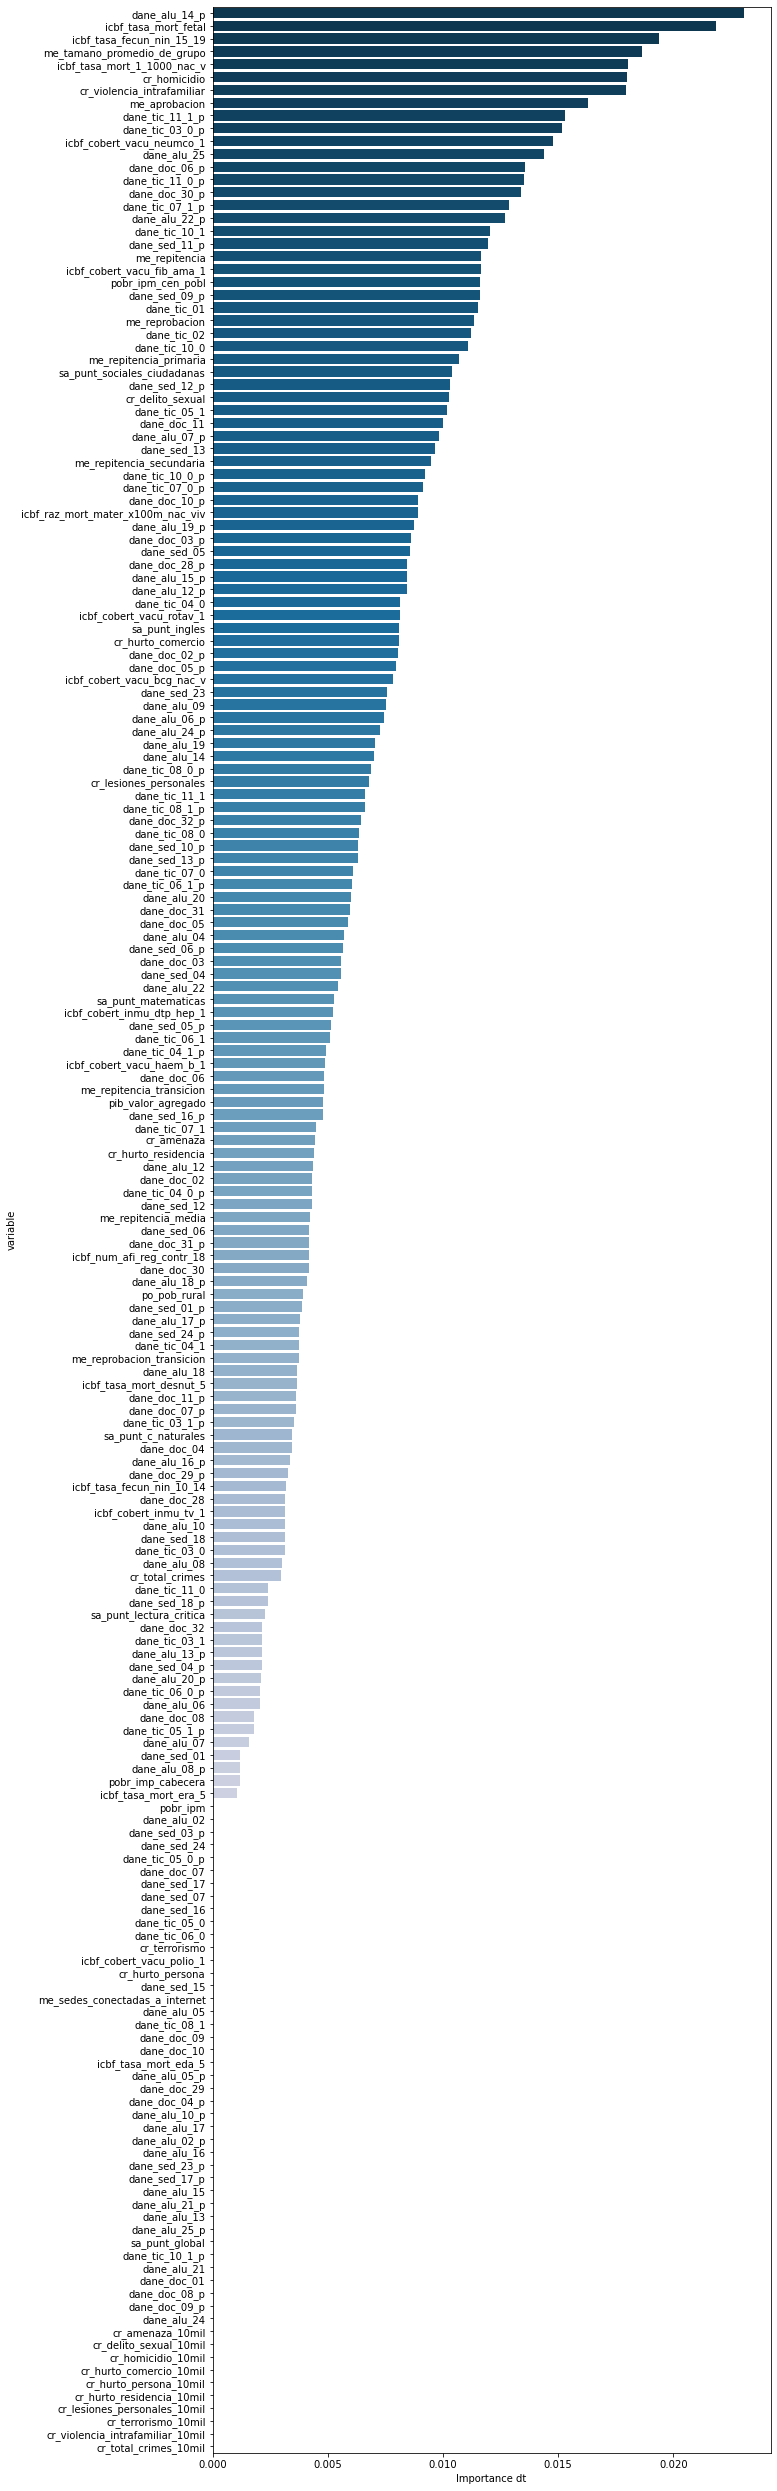

In [22]:
start_time = time.time()
#Imputar valores faltantes
mun_nomiss=mun.copy()
mun_nomiss=mun_nomiss.fillna(mun_nomiss.median())

vars_drop = list(['name_dept', 'code_dept', 'name_municip', 'code_municip', 'year_cohort'
                  ,'desertion_perc', 'desertion_no', 'latitude', 'longitude', 'region','deser_perc_rank'
                  ,'me_cobertura_neta'
                  ,'me_desercion_transicion','me_desercion_primaria','me_desercion_secundaria','me_desercion_media'
#Variables con alto missing (mas de 30%)
                  ,'dane_sed_20','dane_sed_20_p','dane_sed_14','icbf_num_nin_adol_desvinc'
#Variables de escalafon docente que se cambiaron por nueva agrupacion (Luis)
                  ,'dane_doc_12_p','dane_doc_13_p','dane_doc_14_p','dane_doc_15_p','dane_doc_16_p','dane_doc_17_p','dane_doc_18_p','dane_doc_19_p','dane_doc_20_p','dane_doc_21_p','dane_doc_22_p','dane_doc_23_p','dane_doc_24_p','dane_doc_25_p','dane_doc_26_p','dane_doc_27_p','dane_doc_12','dane_doc_13','dane_doc_14','dane_doc_15','dane_doc_16','dane_doc_17','dane_doc_18','dane_doc_19','dane_doc_20','dane_doc_21','dane_doc_22','dane_doc_23','dane_doc_24','dane_doc_25','dane_doc_26','dane_doc_27'
#Eliminadas por seleccion una a una:
                  ,'me_aprobacion','me_tasa_matriculacion_5_16','me_aprobacion_transicion','dane_alu_11','me_aprobacion_primaria','me_cobertura_bruta','po_pob_total','me_cobertura_neta_secundaria','me_cobertura_neta_primaria','me_aprobacion_secundaria','icbf_num_afi_reg_subs_18','me_aprobacion_media','me_cobertura_bruta_secundaria','dane_sed_10','po_pob_cabecera','me_cobertura_bruta_primaria','me_enrolled_students_n','dane_alu_11_p','dane_alu_09_p','me_poblacion_5_16','dane_sed_03','me_reprobacion_secundaria','dane_sed_08','me_cobertura_bruta_media','me_reprobacion_media','dane_sed_09','dane_alu_23','dane_alu_23_p','me_cobertura_neta_media','dane_alu_01','me_cobertura_neta_transicion','me_cobertura_bruta_transicion','dane_sed_02_p','dane_sed_11','dane_sed_02','me_reprobacion_primaria'

])

X_all=mun_nomiss.drop(vars_drop, axis=1)

y=mun_nomiss['deser_perc_rank']

clf = DecisionTreeClassifier(random_state=12345)
clf = clf.fit(X_all, y)
features_imp_dt=dict(zip(X_all.columns, clf.feature_importances_))
features_imp_dt=pd.DataFrame.from_dict(features_imp_dt, orient='index').reset_index()
features_imp_dt.rename(columns={'index':'variable',0:'Importance dt'},inplace=True)
features_imp_dt=features_imp_dt.sort_values(by='Importance dt', ascending=False)
features_imp_dt.to_clipboard(index=False,header=True)

plt.figure(figsize=(10,45))
ax = sns.barplot(x="Importance dt", y="variable", data=features_imp_dt,palette="PuBu_r")

print("Ejecución: %s seconds" % (time.time() - start_time))

### Ajuste del modelo

In [21]:
start_time = time.time()
feature_cols = ['dane_alu_09','me_aprobacion','sa_punt_matematicas','dane_alu_24','pib_valor_agregado','me_reprobacion','dane_alu_12','dane_tic_01','icbf_num_afi_reg_contr_18','po_pob_rural']

X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return metrics.roc_auc_score(y_test, y_pred, average=average)
print("AUROC train:",multiclass_roc_auc_score(y_train,y_pred_train))
print("AUROC test:",multiclass_roc_auc_score(y_test,y_pred_test))
print("Accuracy train:",metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy test:",metrics.accuracy_score(y_test, y_pred_test))
print("Recall (Sensitivity) train:",metrics.recall_score(y_train, y_pred_train, average=None))
print("Recall (Sensitivity) test:",metrics.recall_score(y_test, y_pred_test, average=None))
print("F1 Score train:",metrics.f1_score(y_train, y_pred_train, average=None))
print("F1 Score test:",metrics.f1_score(y_test, y_pred_test, average=None))
pd.DataFrame(metrics.confusion_matrix(y_pred_test,y_test)).to_clipboard(index=True,header=True)
print("Ejecución: %s seconds" % (time.time() - start_time))

KeyError: "['me_aprobacion'] not in index"

# Ajuste de XG-Boost
### Feature selection

Ejecución: 6.640746355056763 seconds


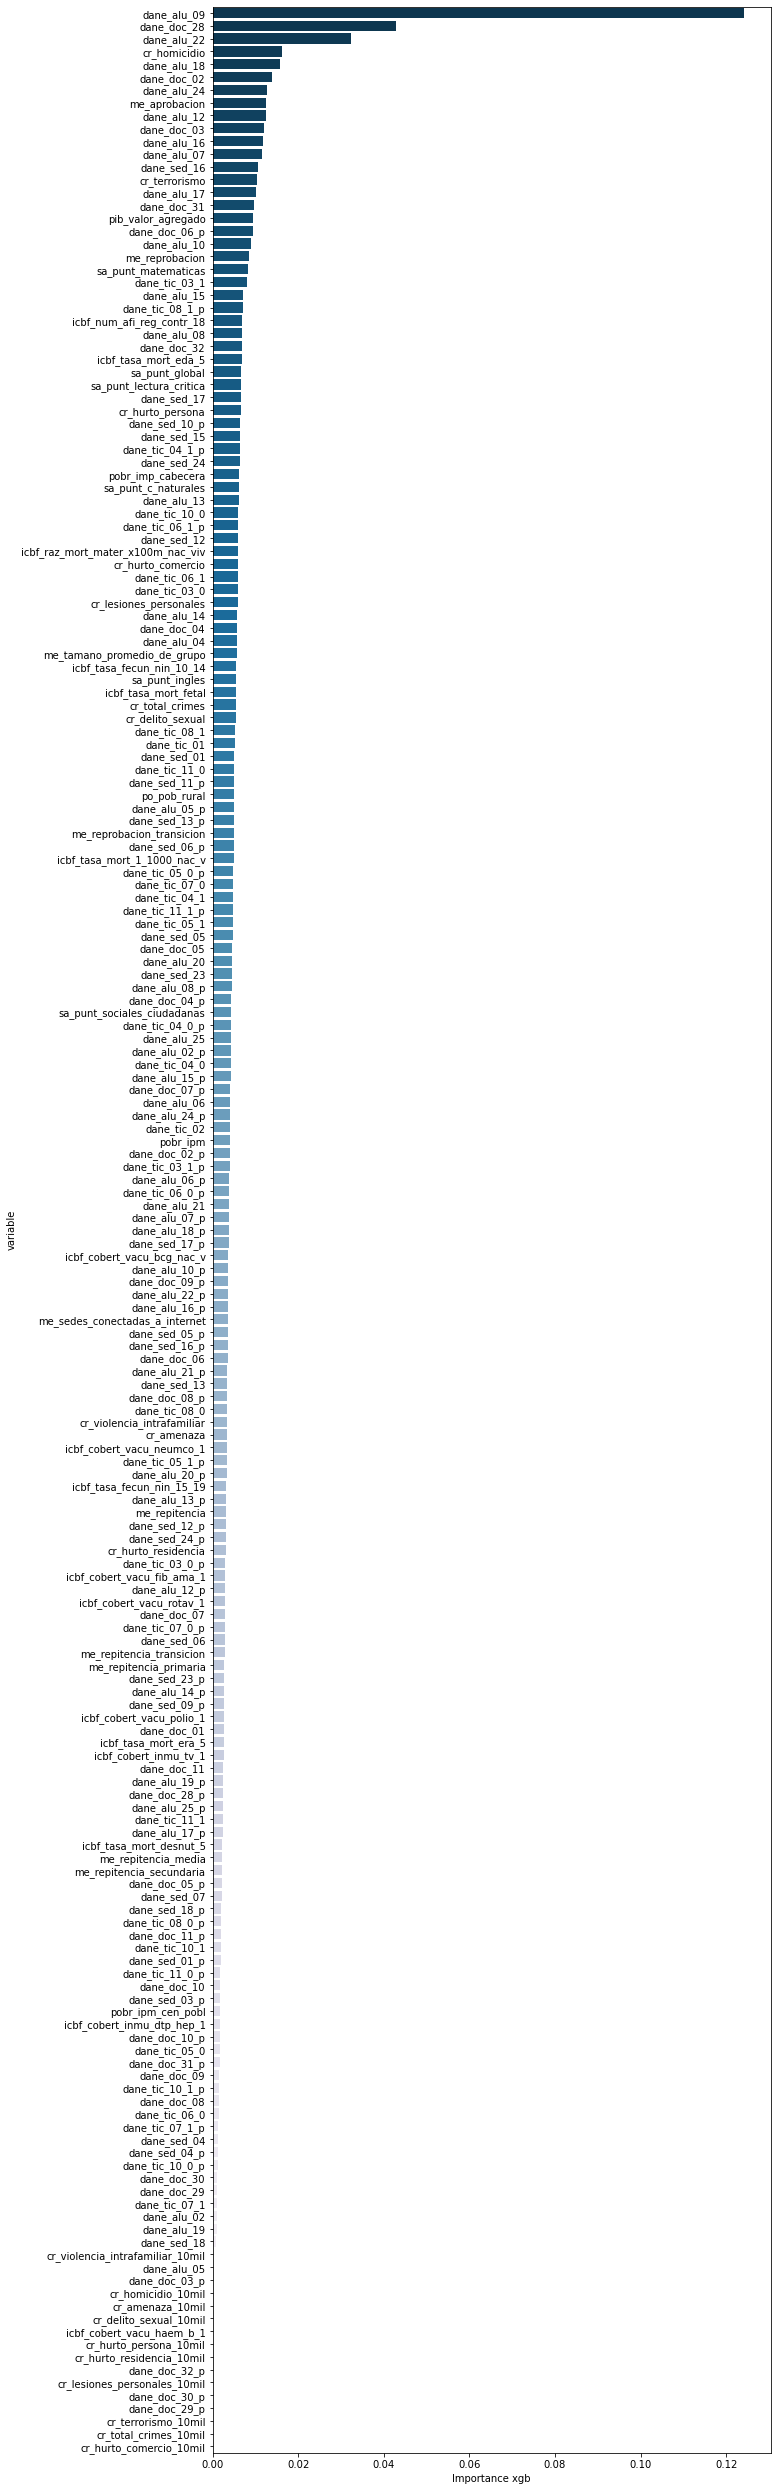

In [169]:
start_time = time.time()
X_all=mun_nomiss.drop(vars_drop, axis=1)

y=mun_nomiss['deser_perc_rank']

# define the model
xgb_model = XGBClassifier()
# fit the model
xgb_model =xgb_model.fit(X_all, y)
# get importance
 
features_imp_xgb=dict(zip(X_all.columns, xgb_model.feature_importances_))
features_imp_xgb=pd.DataFrame.from_dict(features_imp_xgb, orient='index').reset_index()
features_imp_xgb.rename(columns={'index':'variable',0:'Importance xgb'},inplace=True)
features_imp_xgb=features_imp_xgb.sort_values(by='Importance xgb', ascending=False)
features_imp_xgb.to_clipboard(index=False,header=True)

plt.figure(figsize=(10,45))
ax = sns.barplot(x="Importance xgb", y="variable", data=features_imp_xgb,palette="PuBu_r")
print("Ejecución: %s seconds" % (time.time() - start_time))

### Ajuste del modelo

In [170]:
start_time = time.time()
feature_cols = ['dane_alu_09','dane_doc_28','dane_alu_22','cr_homicidio','dane_alu_18','dane_doc_02','dane_alu_24','me_aprobacion','dane_alu_12','dane_doc_03']


X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

xgb1 = XGBClassifier()
parameters = {'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 5,n_jobs = -1,verbose=False)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print("Ejecución: %s seconds" % (time.time() - start_time))

0.6216387337057727
{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5}
Ejecución: 114.13770008087158 seconds


In [171]:
start_time = time.time()
X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
xgb = XGBClassifier(random_state=12345,learning_rate=0.1,max_depth=5,min_child_weight=5)
xgb = xgb.fit(X_train,y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return metrics.roc_auc_score(y_test, y_pred, average=average)
print("AUROC train:",multiclass_roc_auc_score(y_train,y_pred_train))
print("AUROC test:",multiclass_roc_auc_score(y_test,y_pred_test))
print("Accuracy train:",metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy test:",metrics.accuracy_score(y_test, y_pred_test))
print("Recall (Sensitivity) train:",metrics.recall_score(y_train, y_pred_train, average=None))
print("Recall (Sensitivity) test:",metrics.recall_score(y_test, y_pred_test, average=None))
print("F1 Score train:",metrics.f1_score(y_train, y_pred_train, average=None))
print("F1 Score test:",metrics.f1_score(y_test, y_pred_test, average=None))
pd.DataFrame(metrics.confusion_matrix(y_pred_test,y_test)).to_clipboard(index=True,header=True)
print("Ejecución: %s seconds" % (time.time() - start_time))

AUROC train: 0.9557430305191599
AUROC test: 0.7474941539974785
Accuracy train: 0.9341517857142857
Accuracy test: 0.6205357142857143
Recall (Sensitivity) train: [0.88669951 0.96135266 0.93639576 0.95073892]
Recall (Sensitivity) test: [0.52380952 0.71666667 0.50704225 0.74509804]
F1 Score train: [0.91603053 0.93867925 0.9314587  0.95073892]
F1 Score test: [0.51162791 0.7107438  0.52941176 0.72380952]
Ejecución: 1.0081686973571777 seconds


# Ajuste de Random Forest
### Feature selection

Ejecución: 2.118896007537842 seconds


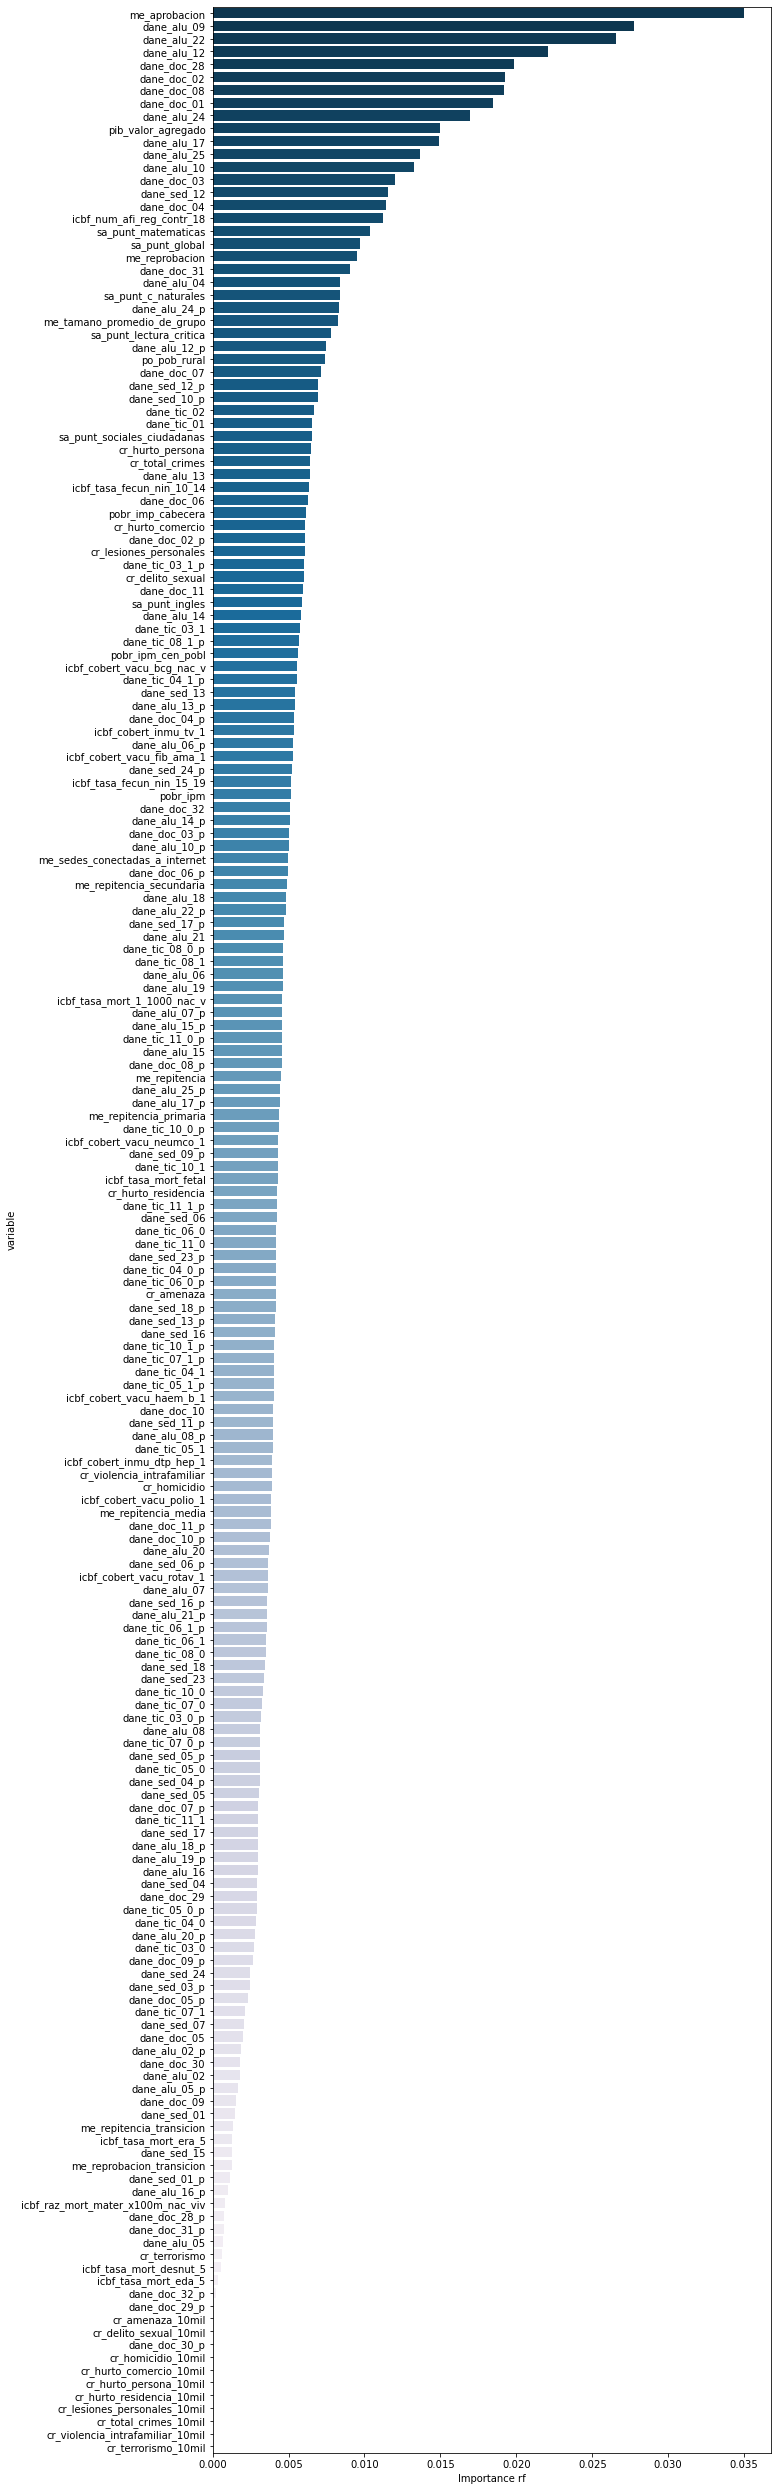

In [172]:
start_time = time.time()
X_all=mun_nomiss.drop(vars_drop, axis=1)

y=mun_nomiss['deser_perc_rank']

# define the model
rf_model = RandomForestClassifier()
# fit the model
rf_model = rf_model.fit(X_all, y)
# get importance
 
features_imp_rf=dict(zip(X_all.columns, rf_model.feature_importances_))
features_imp_rf=pd.DataFrame.from_dict(features_imp_rf, orient='index').reset_index()
features_imp_rf.rename(columns={'index':'variable',0:'Importance rf'},inplace=True)
features_imp_rf=features_imp_rf.sort_values(by='Importance rf', ascending=False)
features_imp_rf.to_clipboard(index=False,header=True)

plt.figure(figsize=(10,45))
ax = sns.barplot(x="Importance rf", y="variable", data=features_imp_rf,palette="PuBu_r")
print("Ejecución: %s seconds" % (time.time() - start_time))

### Ajuste del modelo

In [173]:
start_time = time.time()
feature_cols = ['me_aprobacion','dane_alu_09','dane_alu_22','dane_alu_12','dane_doc_28','dane_doc_02','dane_doc_08','dane_doc_01','dane_alu_24','pib_valor_agregado']


X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

rf1 = RandomForestClassifier()
parameters = {'n_estimators':range(1,100,20),
    'max_depth':range(3,10,2),
    'min_samples_split':range(5,20,5),
    'min_samples_leaf':range(5,20,5)}

rf_grid = GridSearchCV(rf1,parameters,cv = 5,n_jobs = -1,verbose=False)

rf_grid.fit(X_train,y_train)

print(rf_grid.best_score_)
print(rf_grid.best_params_)
print("Ejecución: %s seconds" % (time.time() - start_time))

0.6272129112352576
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 81}
Ejecución: 55.60054898262024 seconds


In [174]:
start_time = time.time()
X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
rf = RandomForestClassifier(random_state=12345,max_depth= 5, min_samples_leaf= 5, min_samples_split= 15, n_estimators= 81)
rf = rf.fit(X_train,y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return metrics.roc_auc_score(y_test, y_pred, average=average)
print("AUROC train:",multiclass_roc_auc_score(y_train,y_pred_train))
print("AUROC test:",multiclass_roc_auc_score(y_test,y_pred_test))
print("Accuracy train:",metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy test:",metrics.accuracy_score(y_test, y_pred_test))
print("Recall (Sensitivity) train:",metrics.recall_score(y_train, y_pred_train, average=None))
print("Recall (Sensitivity) test:",metrics.recall_score(y_test, y_pred_test, average=None))
print("F1 Score train:",metrics.f1_score(y_train, y_pred_train, average=None))
print("F1 Score test:",metrics.f1_score(y_test, y_pred_test, average=None))
pd.DataFrame(metrics.confusion_matrix(y_pred_test,y_test)).to_clipboard(index=True,header=True)
print("Ejecución: %s seconds" % (time.time() - start_time))

AUROC train: 0.7958006439555518
AUROC test: 0.7377559373020259
Accuracy train: 0.6975446428571429
Accuracy test: 0.6205357142857143
Recall (Sensitivity) train: [0.51231527 0.76328502 0.71378092 0.79310345]
Recall (Sensitivity) test: [0.35714286 0.71666667 0.6056338  0.74509804]
F1 Score train: [0.61176471 0.73488372 0.65691057 0.79115479]
F1 Score test: [0.4109589  0.72881356 0.55483871 0.74509804]
Ejecución: 0.42580175399780273 seconds


In [175]:
features_imp_dt=features_imp_dt.rename_axis('posicion dt').reset_index()
features_imp_dt['posicion dt']=features_imp_dt.index

features_imp_xgb=features_imp_xgb.rename_axis('posicion xgb').reset_index()
features_imp_xgb['posicion xgb']=features_imp_xgb.index

features_imp_rf=features_imp_rf.rename_axis('posicion rf').reset_index()
features_imp_rf['posicion rf']=features_imp_rf.index

features_all=pd.merge(features_imp_dt, features_imp_xgb, how='left', on="variable")
features_all=pd.merge(features_all, features_imp_rf, how='left', on="variable")
features_all['posicion_final']=features_all['posicion dt']+features_all['posicion xgb']+features_all['posicion rf']
features_all=features_all.sort_values(by=['posicion_final'])
features_all[['variable','posicion_final']].to_clipboard(index=False,header=True)

In [43]:
mun.columns

Index(['name_dept', 'code_dept', 'name_municip', 'code_municip', 'year_cohort',
       'desertion_perc', 'desertion_no', 'latitude', 'longitude', 'region',
       ...
       'icbf_tasa_mort_desnut_5', 'icbf_tasa_mort_eda_5',
       'icbf_tasa_mort_era_5', 'me_tamano_promedio_de_grupo',
       'me_sedes_conectadas_a_internet', 'pib_valor_agregado', 'pobr_ipm',
       'pobr_imp_cabecera', 'pobr_ipm_cen_pobl', 'deser_perc_rank'],
      dtype='object', length=276)

In [187]:
mun['dane_doc_31_p'].describe()

count    1120.000000
mean        0.172321
std         0.377828
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: dane_doc_31_p, dtype: float64

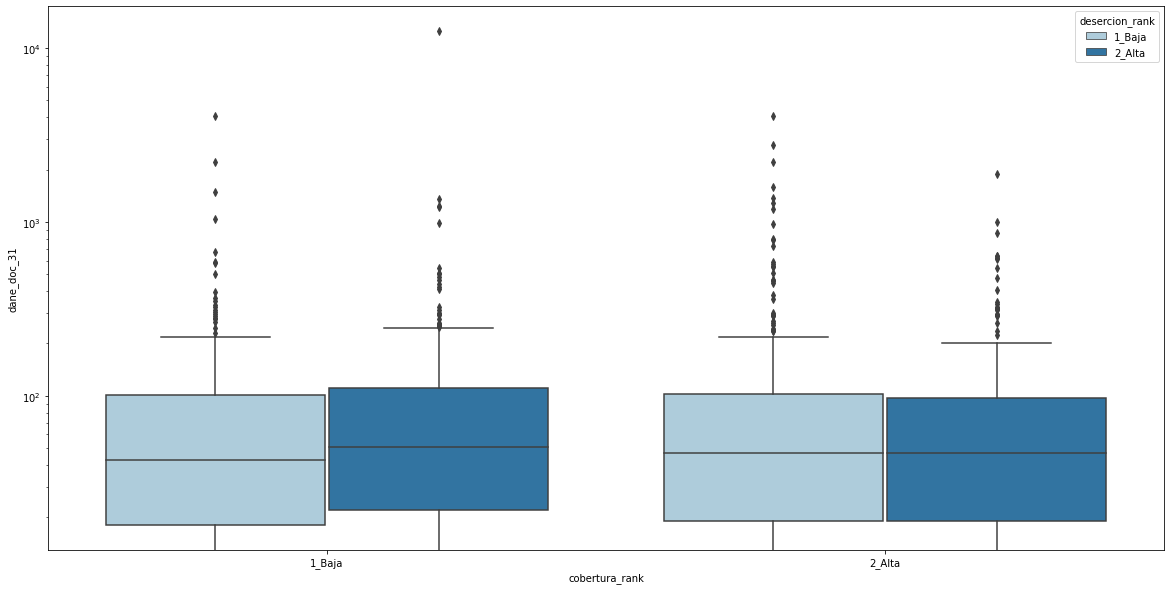

In [28]:
var="dane_doc_31"
fig, axes = plt.subplots(1,1,figsize=(20,10)) # create figure and axes
fig = px.scatter(mun, x=var, y="desertion_perc", width=900,height =350,hover_name='name_municip'
                 ,log_x=True
                 ,color="deser_perc_rank")
fig.show()
#a=sns.violinplot(x="deser_perc_rank", y=var, data=mun, palette="Paired",order=['1_DS_Alta-CB_Baja','2_DS_Baja-CB_Baja','4_DS_Alta-CB_Alta','3_DS_Baja-CB_Alta'])
#a=sns.boxplot(x="deser_perc_rank", y=var, data=mun, palette="Paired",order=['1_DS_Alta-CB_Baja','2_DS_Baja-CB_Baja','4_DS_Alta-CB_Alta','3_DS_Baja-CB_Alta'])
#a=sns.swarmplot(x="deser_perc_rank", y=var, data=mun, palette="Paired",order=['1_DS_Alta-CB_Baja','2_DS_Baja-CB_Baja','4_DS_Alta-CB_Alta','3_DS_Baja-CB_Alta'])
a = sns.boxplot(x="cobertura_rank", y=var, hue="desercion_rank",data=mun, palette="Paired")
a.set_yscale('log')


### Imputar valores faltantes

In [60]:
#Mantener solo columnas con bajo % de missing
mun_nomiss=mun.copy()

vars_drop = list(['cr_terrorismo','icbf_cobert_inmu_dtp_hep_1','icbf_cobert_inmu_tv_1','icbf_cobert_vacu_bcg_nac_v','icbf_cobert_vacu_fib_ama_1','icbf_cobert_vacu_haem_b_1','icbf_cobert_vacu_neumco_1','icbf_cobert_vacu_polio_1','icbf_cobert_vacu_rotav_1','icbf_num_afi_reg_contr_18','icbf_num_afi_reg_subs_18','icbf_num_nin_adol_desvinc','icbf_raz_mort_mater_x100m_nac_viv','icbf_tasa_fecun_nin_10_14','icbf_tasa_fecun_nin_15_19','icbf_tasa_mort_1_1000_nac_v','icbf_tasa_mort_fetal','icbf_tasa_mort_desnut_5','icbf_tasa_mort_eda_5','icbf_tasa_mort_era_5','me_tamano_promedio_de_grupo','me_sedes_conectadas_a_internet','pib_valor_agregado','dane_tic_11','dane_sed_20','dane_sed_21','dane_sed_14'])
mun_nomiss.drop(vars_drop, axis=1, inplace=True)
mun_nomiss.shape

#Por ahora se imputan los valores faltantes usando la mediana de cada variable. 
#Se debe evaluar si es la mejor forma de imputación o se debe usar otra
mun_nomiss=mun_nomiss.fillna(mun_nomiss.median())

C:\Users\Daniel_Jimenez\Documents\programas_Data_science\Anaconda\envs\desertion_project\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Exception ignored in: <function _ConnectionRecord.checkout.<locals>.<lambda> at 0x000001F07409BDC8>
Traceback (most recent call last):
  File "C:\Users\Daniel_Jimenez\Documents\programas_Data_science\Anaconda\envs\desertion_project\lib\site-packages\sqlalchemy\pool\base.py", line 506, in <lambda>
    and _finalize_fairy(None, rec, pool, ref, echo),
  File "C:\Users\Daniel_Jimenez\Documents\programas_Data_science\Anaconda\envs\desertion_project\lib\site-packages\sqlalchemy\pool\base.py", line 714, in _finalize_fairy
    connection_record.checkin()
  File "C:\Users\Daniel_Jimenez\Documents\programas_Data_science\Anaconda\envs\desertion_project\lib\site-packages\sqlalchemy\pool\base.py", line 528, in checkin
    finalizer(connection)
  File "C:\Users\Daniel_Jimenez\Documents\programas_Data_science\Anaconda\envs\desertion_project\lib\site-packages\sqlalchemy\engine\default.py", line 605, in reset_isolation_level
    self.set_isolation_level(dbapi_conn, self.default_isolation_level)
  File 

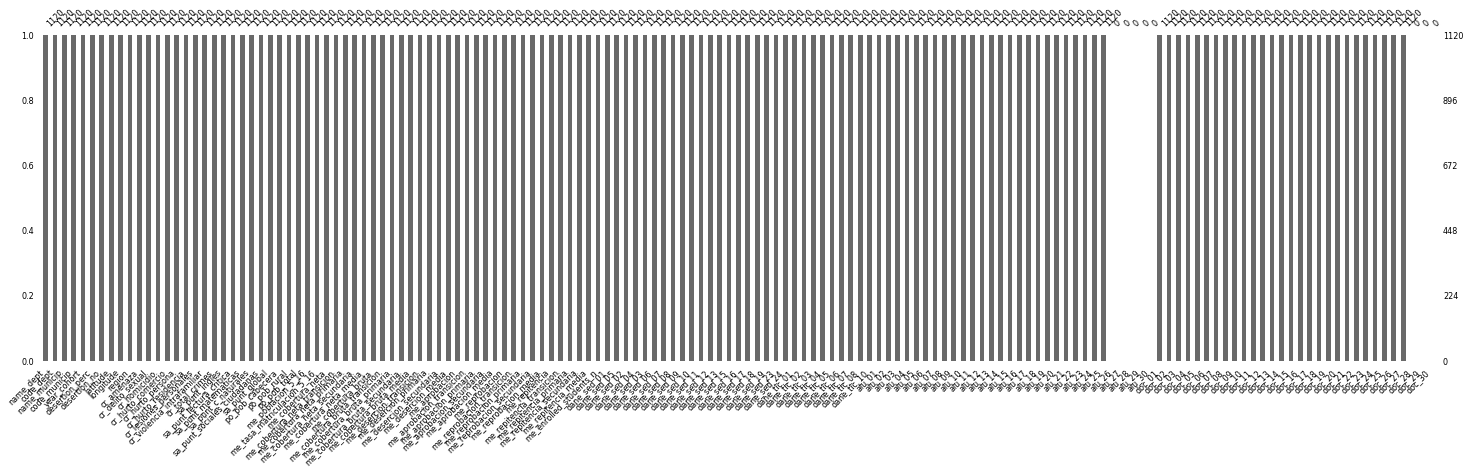

In [61]:
msno.bar(mun_nomiss, labels=True, figsize=(25,6), fontsize=8)

### Inspeccionar valores atipicos

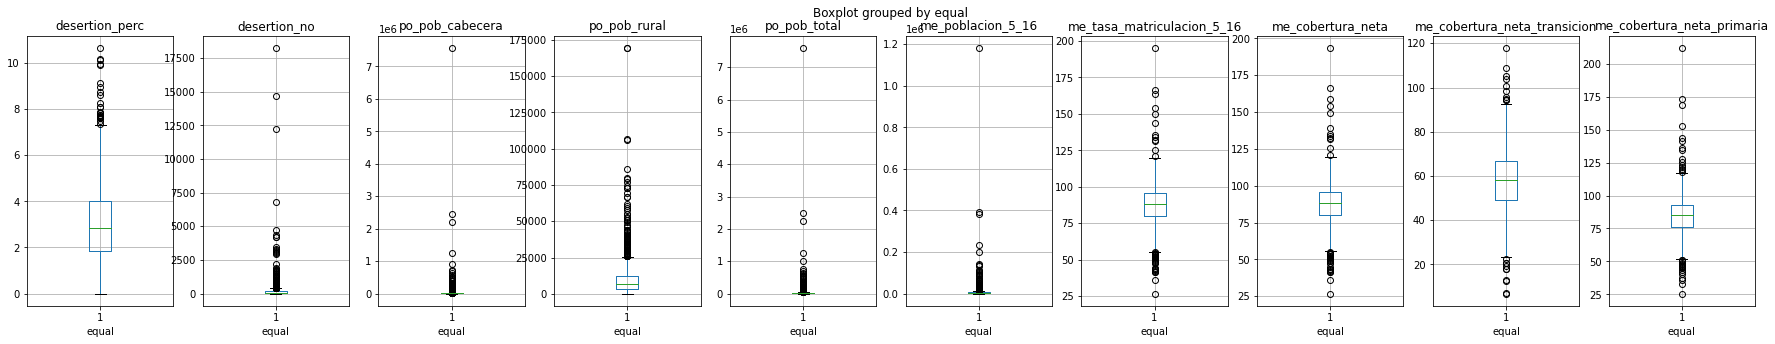

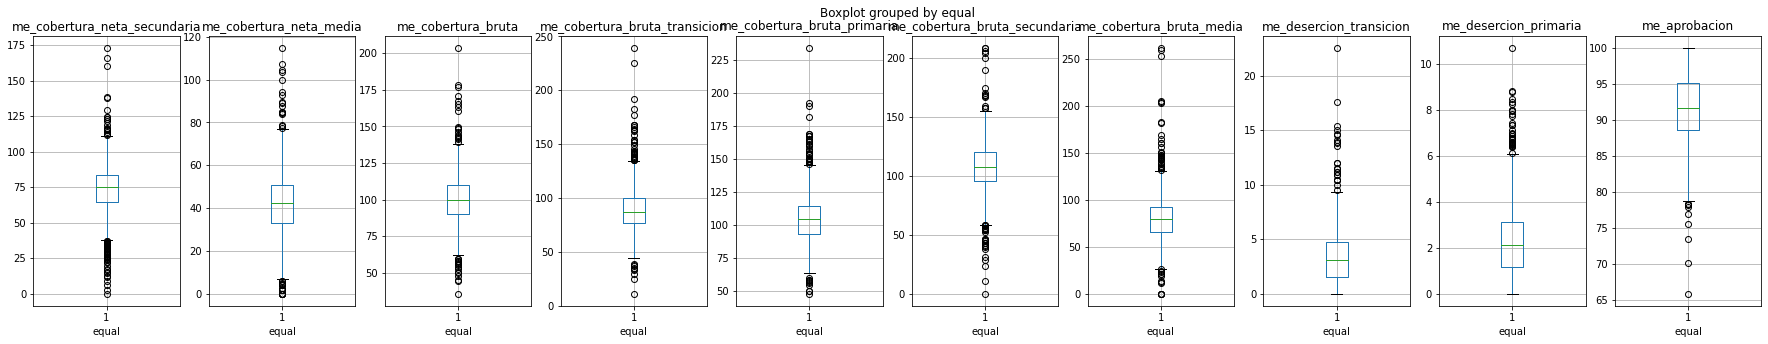

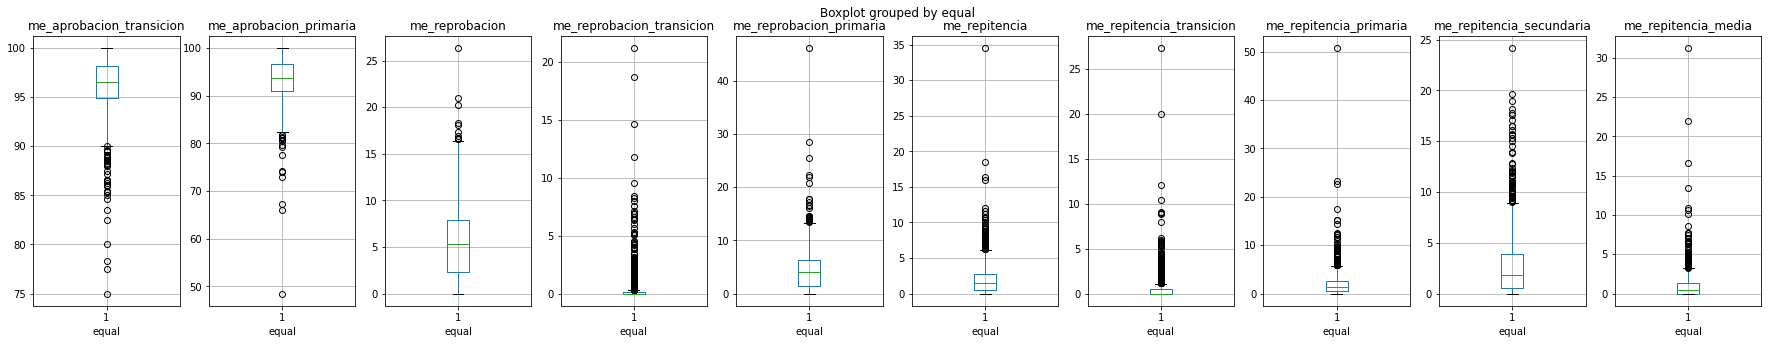

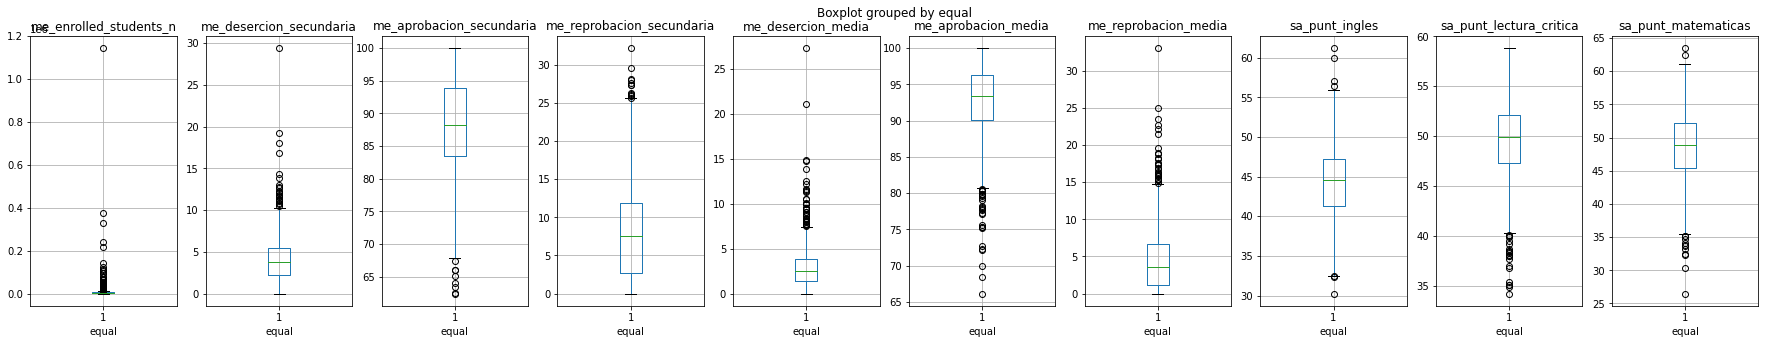

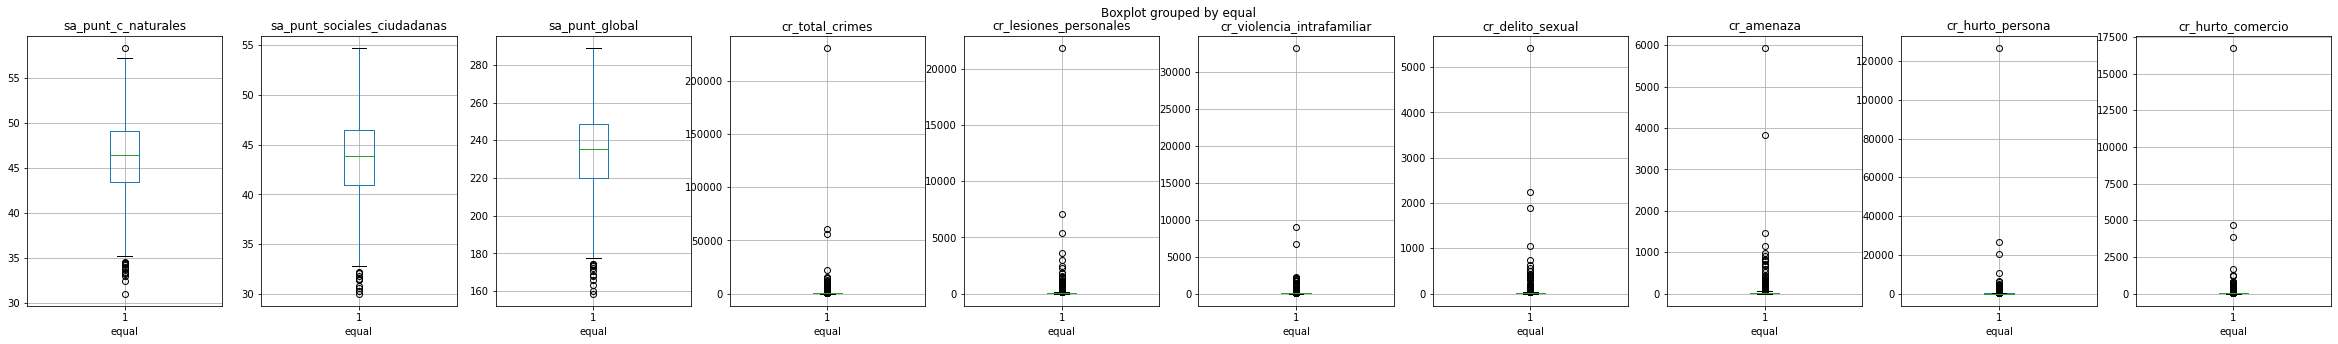

In [9]:
vars_boxplot=list(['desertion_perc','desertion_no','po_pob_cabecera','po_pob_rural','po_pob_total','me_poblacion_5_16','me_tasa_matriculacion_5_16','me_cobertura_neta','me_cobertura_neta_transicion','me_cobertura_neta_primaria','me_cobertura_neta_secundaria','me_cobertura_neta_media','me_cobertura_bruta','me_cobertura_bruta_transicion','me_cobertura_bruta_primaria','me_cobertura_bruta_secundaria','me_cobertura_bruta_media','me_desercion_transicion','me_desercion_primaria','me_aprobacion','me_aprobacion_transicion','me_aprobacion_primaria','me_reprobacion','me_reprobacion_transicion','me_reprobacion_primaria','me_repitencia','me_repitencia_transicion','me_repitencia_primaria','me_repitencia_secundaria','me_repitencia_media','me_enrolled_students_n','me_desercion_secundaria','me_aprobacion_secundaria','me_reprobacion_secundaria','me_desercion_media','me_aprobacion_media','me_reprobacion_media','sa_punt_ingles','sa_punt_lectura_critica','sa_punt_matematicas','sa_punt_c_naturales','sa_punt_sociales_ciudadanas','sa_punt_global','cr_total_crimes','cr_lesiones_personales','cr_violencia_intrafamiliar','cr_delito_sexual','cr_amenaza','cr_hurto_persona','cr_hurto_comercio','cr_hurto_residencia','cr_homicidio'])
#vars_boxplot=list(['desertion_perc','desertion_no','po_pob_cabecera','po_pob_rural'])
mun_nomiss['equal']=1

fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i+10],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i+20],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i+30],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(40, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i+40],'equal', ax=ax[i])

### Acotar variables por valores atípicos (percentiles 5 y 95)

In [10]:
percentile_df = mun_nomiss.set_index(['name_dept', 'code_dept', 'name_municip', 'code_municip', 'year_cohort', 'latitude', 'longitude', 'region']).apply(lambda x: np.clip(x, *np.percentile(x, [5,95]))).reset_index()

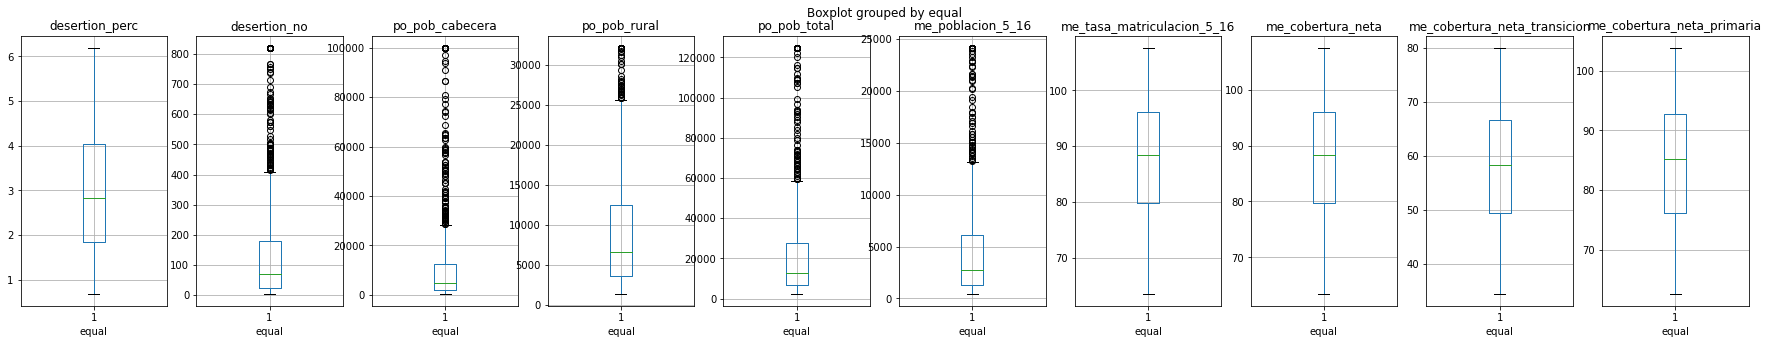

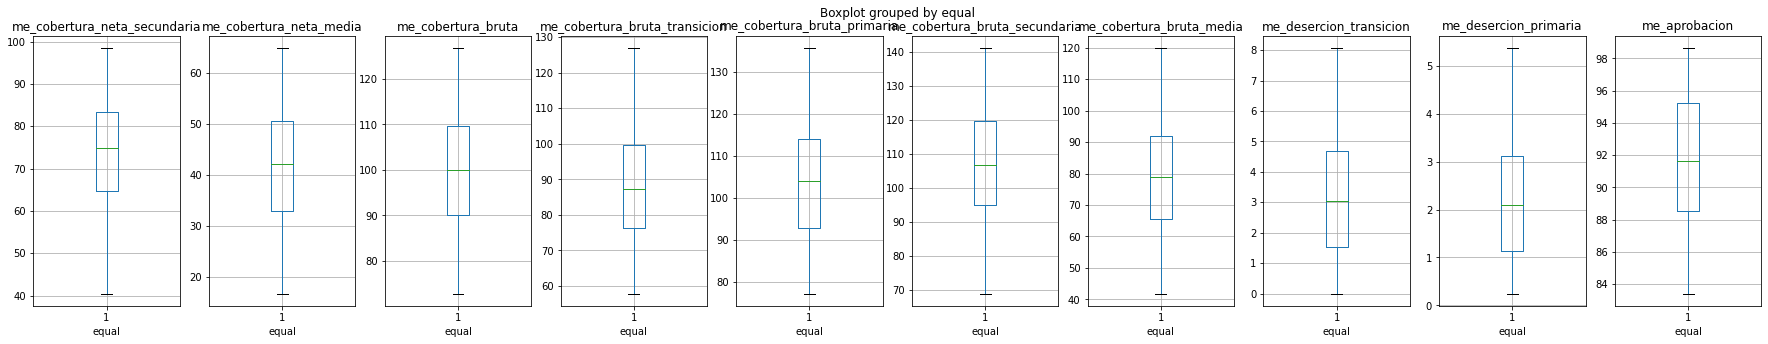

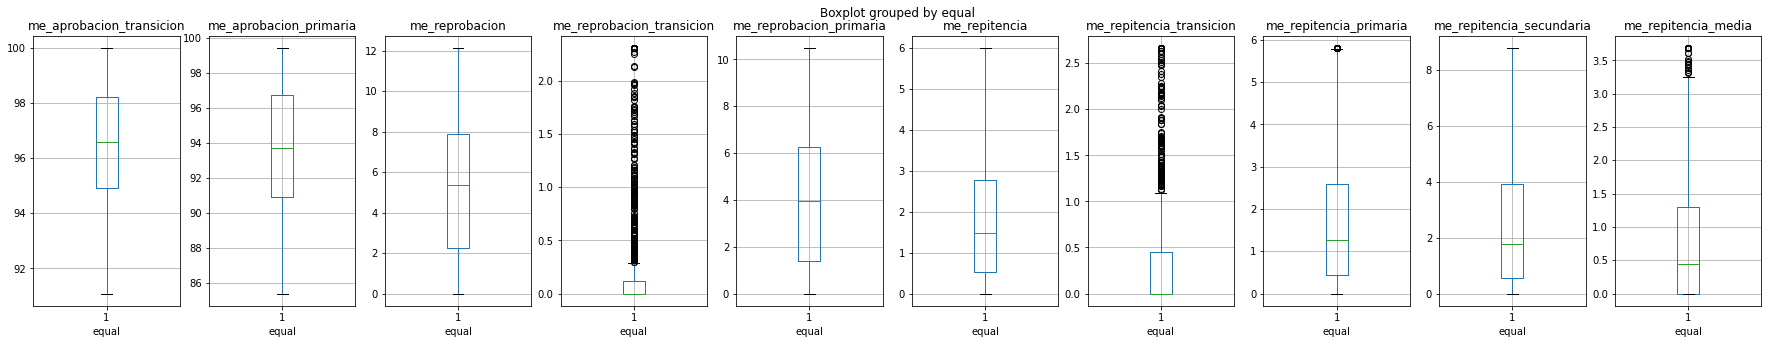

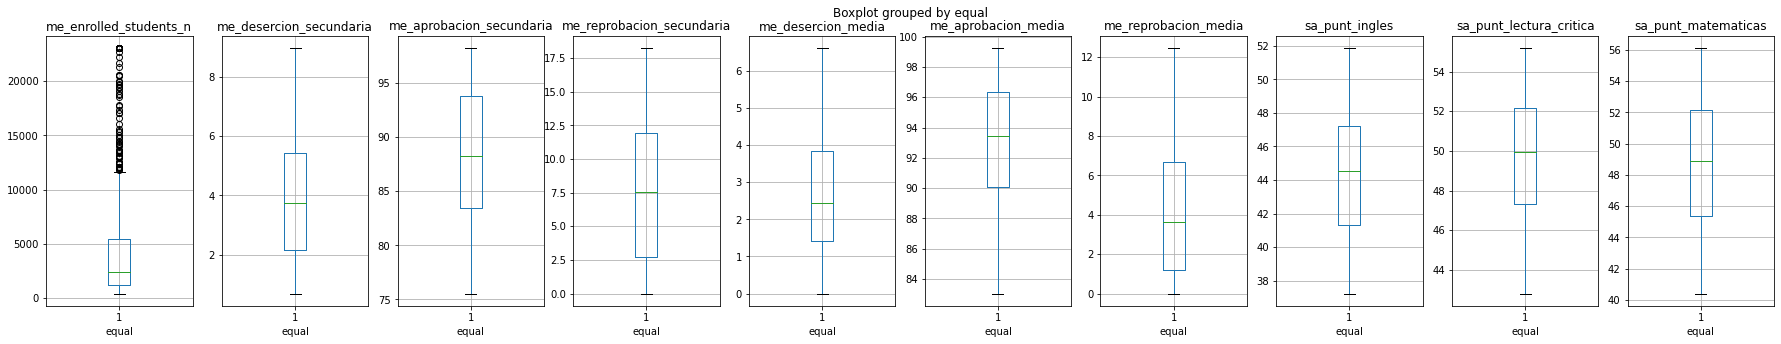

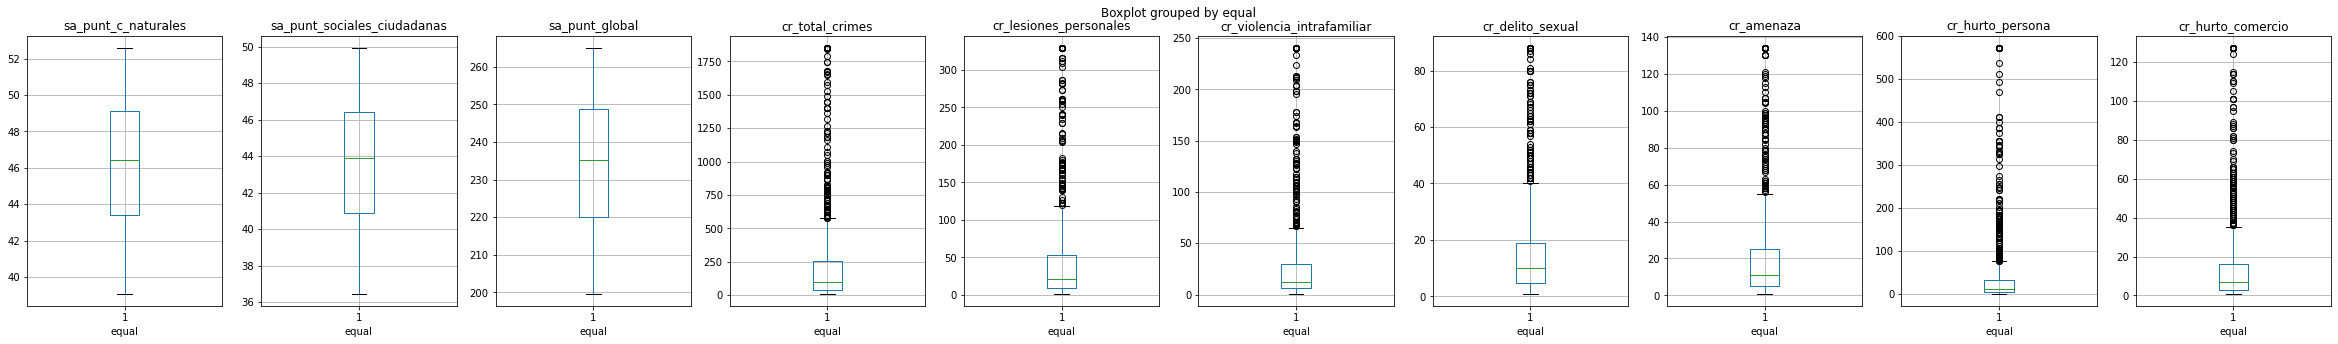

In [11]:
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i+10],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i+20],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i+30],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(40, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i+40],'equal', ax=ax[i])

### Rankear deserción usando Kmeans (Alto, Medio, Bajo)

In [12]:
mun_nomiss.columns

Index(['name_dept', 'code_dept', 'name_municip', 'code_municip', 'year_cohort',
       'desertion_perc', 'desertion_no', 'latitude', 'longitude', 'region',
       'cr_amenaza', 'cr_delito_sexual', 'cr_homicidio', 'cr_hurto_comercio',
       'cr_hurto_persona', 'cr_hurto_residencia', 'cr_lesiones_personales',
       'cr_violencia_intrafamiliar', 'cr_total_crimes', 'sa_punt_ingles',
       'sa_punt_lectura_critica', 'sa_punt_matematicas', 'sa_punt_c_naturales',
       'sa_punt_sociales_ciudadanas', 'sa_punt_global', 'po_pob_cabecera',
       'po_pob_rural', 'po_pob_total', 'me_poblacion_5_16',
       'me_tasa_matriculacion_5_16', 'me_cobertura_neta',
       'me_cobertura_neta_transicion', 'me_cobertura_neta_primaria',
       'me_cobertura_neta_secundaria', 'me_cobertura_neta_media',
       'me_cobertura_bruta', 'me_cobertura_bruta_transicion',
       'me_cobertura_bruta_primaria', 'me_cobertura_bruta_secundaria',
       'me_cobertura_bruta_media', 'me_desercion_transicion',
       'me_de

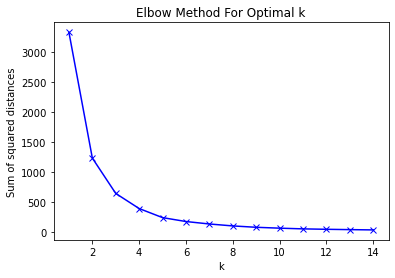

In [13]:
#Usar solo la desercion
desertion=pd.DataFrame(mun_nomiss['desertion_perc'])
#Número de cluster óptimo
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=12345)
    km = km.fit(desertion)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

C:\Users\Daniel_Jimenez\Documents\programas_Data_science\Anaconda\envs\desertion_project\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


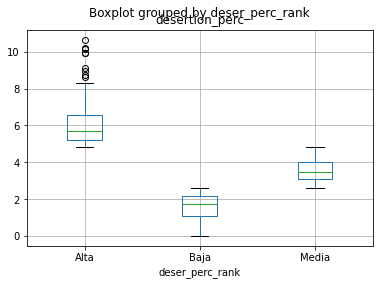

In [14]:
#Ajustar Kmeans con 3 grupos
km = KMeans(n_clusters=3, random_state=12345).fit(desertion)
mun_nomiss['deser_perc_rank']=km.labels_
mun_nomiss['deser_perc_rank']=np.where(mun_nomiss['deser_perc_rank'] == 1, 'Baja'
                                       , np.where(mun_nomiss['deser_perc_rank'] == 0, 'Media','Alta'))
mun_nomiss.boxplot('desertion_perc','deser_perc_rank')

# Ajuste de árbol de decisión 
### Feature selection

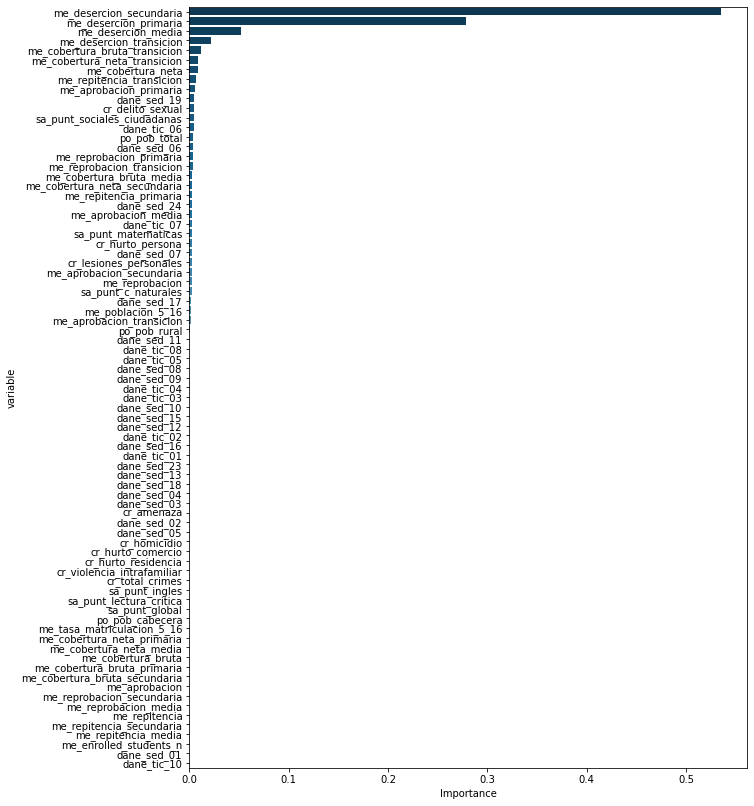

In [15]:
vars_drop = list(['name_dept', 'code_dept', 'name_municip', 'code_municip', 'year_cohort',
       'desertion_perc', 'desertion_no', 'latitude', 'longitude', 'region','equal','deser_perc_rank'])
X_all=mun_nomiss.drop(vars_drop, axis=1)

y=mun_nomiss['deser_perc_rank']

clf = DecisionTreeClassifier(random_state=12345)
clf = clf.fit(X_all, y)
features_imp=dict(zip(X_all.columns, clf.feature_importances_))
features_imp=pd.DataFrame.from_dict(features_imp, orient='index').reset_index()
features_imp.rename(columns={'index':'variable',0:'Importance'},inplace=True)
features_imp=features_imp.sort_values(by='Importance', ascending=False)
features_imp.to_clipboard(index=False,header=True)

plt.figure(figsize=(10,14))
ax = sns.barplot(x="Importance", y="variable", data=features_imp,palette="PuBu_r")

### Ajuste del modelo

In [26]:
feature_cols = ['me_desercion_secundaria','me_desercion_primaria','me_desercion_media','me_desercion_transicion','me_cobertura_bruta_transicion']
X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return metrics.roc_auc_score(y_test, y_pred, average=average)
print("AUROC train:",multiclass_roc_auc_score(y_train,y_pred_train))
print("AUROC test:",multiclass_roc_auc_score(y_test,y_pred_test))
print("Accuracy train:",metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy test:",metrics.accuracy_score(y_test, y_pred_test))
print("Recall (Sensitivity) train:",metrics.recall_score(y_train, y_pred_train, average=None))
print("Recall (Sensitivity) test:",metrics.recall_score(y_test, y_pred_test, average=None))
print("F1 Score train:",metrics.f1_score(y_train, y_pred_train, average=None))
print("F1 Score test:",metrics.f1_score(y_test, y_pred_test, average=None))
pd.DataFrame(metrics.confusion_matrix(y_pred_test,y_test)).to_clipboard(index=True,header=True)

AUROC train: 0.8887300377702755
AUROC test: 0.8796153193735702
Accuracy train: 0.8872767857142857
Accuracy test: 0.8794642857142857
Recall (Sensitivity) train: [0.68613139 0.99002494 0.84916201]
Recall (Sensitivity) test: [0.66666667 0.96039604 0.86021505]
F1 Score train: [0.79661017 0.93742621 0.85754584]
F1 Score test: [0.78431373 0.92380952 0.85561497]


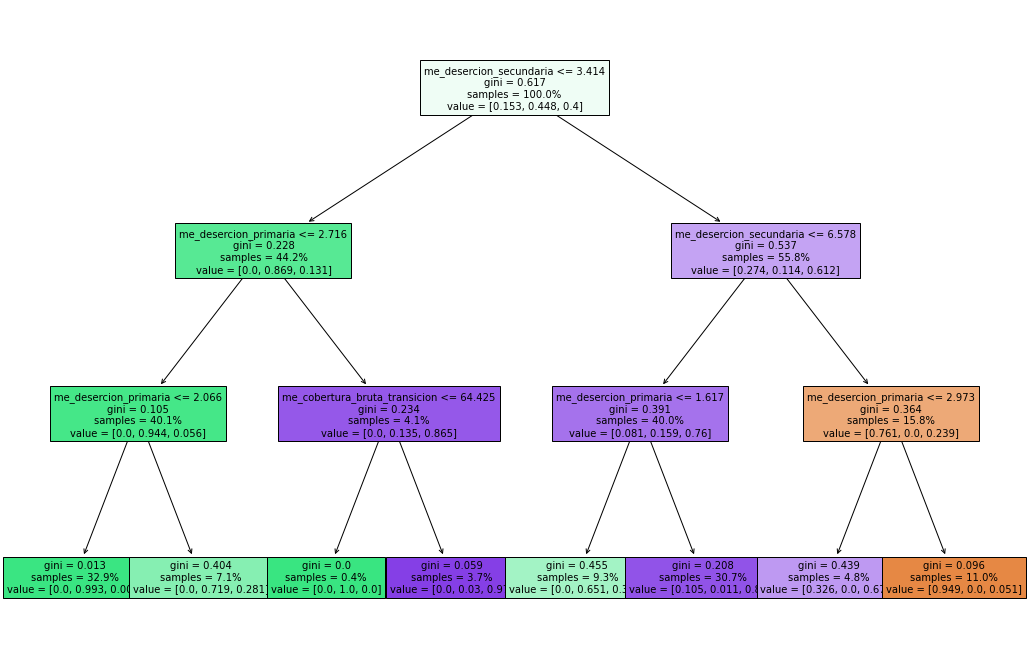

In [22]:
fig, ax = plt.subplots(figsize=(18, 12))
tree.plot_tree(clf, max_depth=4, fontsize=10,feature_names=feature_cols,filled=True,proportion=True)
plt.show()

### Caracterización

In [23]:
categ=np.floor(X[X.columns].rank() / len(X) / .3).astype(int) + 1
categ.columns = [str(col) + '_cat' for col in categ.columns]
result = pd.concat([X, categ], axis=1, sort=False)
result=pd.concat([result, pd.DataFrame(y)], axis=1, sort=False)
result

me_desercion_secundaria  me_desercion_primaria  me_desercion_media  \
0                      5.2982                 3.1019              2.6897   
1                      4.9600                 1.8908              3.9813   
2                      0.0000                 0.6250              2.1277   
3                      3.4965                 1.3423              1.1765   
4                      8.8398                 3.4630              2.8139   
...                       ...                    ...                 ...   
1115                   4.0000                 0.0000              4.5455   
1116                   8.4584                 6.7771              3.9474   
1117                   2.7295                 4.9435              0.4184   
1118                   6.5421                 3.9931              0.0000   
1119                  11.8479                 8.3563              9.4488   

      me_desercion_transicion  me_cobertura_bruta_transicion  \
0                      3.6600                        94.8486   
1                      2.6786                        81.7518   
2                      0.0000                        66.6667   
3                      3.3333                        74.0741   
4                      3.2641                        83.2099   
...                       ...                            ...   
1115                   0.0000                        54.2857   
1116                   8.1365                       105.4762   
1117                   5.6250                        80.4020   
1118                   3.4483                        70.7317   
1119                   6.9887                        45.5951   

      me_desercion_secundaria_cat  me_desercion_primaria_cat  \
0                               3                          3   
1                               3                          2   
2                               1                          1   
3                               2                          2   
4                               4                          3   
...                           ...                        ...   
1115                            2                          1   
1116                            4                          4   
1117                            2                          4   
1118                            3                          3   
1119                            4                          4   

      me_desercion_media_cat  me_desercion_transicion_cat  \
0                          2                            3   
1                          3                            2   
2                          2                            1   
3                          1                            2   
4                          2                            2   
...                      ...                          ...   
1115                       3                            1   
1116                       3                            4   
1117                       1                            3   
1118                       1                            2   
1119                       4                            4   

      me_cobertura_bruta_transicion_cat deser_perc_rank  
0                                     3           Media  
1                                     2           Media  
2                                     1            Baja  
3                                     1            Baja  
4                                     2            Alta  
...                                 ...             ...  
1115                                  1            Baja  
1116                                  3            Alta  
1117                                  2           Media  
1118                                  1           Media  
1119                                  1            Alta  

[1120 rows x 11 columns]

In [20]:
pd.crosstab(result['me_desercion_secundaria_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_desercion_secundaria_cat']).agg({'me_desercion_secundaria':[min,max]})

me_desercion_secundaria         
                                                min      max
me_desercion_secundaria_cat                                 
1                                            0.0000   2.5063
2                                            2.5192   4.2596
3                                            4.2623   7.5881
4                                            7.6284  29.4118

In [21]:
pd.crosstab(result['me_desercion_primaria_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_desercion_primaria_cat']).agg({'me_desercion_primaria':[min,max]})

me_desercion_primaria         
                                            min      max
me_desercion_primaria_cat                               
1                                        0.0000   1.3228
2                                        1.3298   2.4569
3                                        2.4581   4.3333
4                                        4.3414  10.6911

In [22]:
pd.crosstab(result['me_desercion_media_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_desercion_media_cat']).agg({'me_desercion_media':[min,max]})

me_desercion_media         
                                      min      max
me_desercion_media_cat                            
1                                  0.0000   1.6484
2                                  1.6502   2.9070
3                                  2.9155   5.4645
4                                  5.4762  27.2727

In [23]:
pd.crosstab(result['me_desercion_transicion_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_desercion_transicion_cat']).agg({'me_desercion_transicion':[min,max]})

me_desercion_transicion         
                                                min      max
me_desercion_transicion_cat                                 
1                                            0.0000   1.8868
2                                            1.8939   3.6364
3                                            3.6394   6.5574
4                                            6.5728  22.5309

In [24]:
pd.crosstab(result['me_cobertura_bruta_transicion_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_cobertura_bruta_transicion_cat']).agg({'me_cobertura_bruta_transicion':[min,max]})

me_cobertura_bruta_transicion          
                                                            min       max
me_cobertura_bruta_transicion_cat                                        
1                                                       11.2500   78.0172
2                                                       78.1553   91.3636
3                                                       91.4724  114.3491
4                                                      114.7059  239.1304

# Ajuste de XG-Boost
### Feature selection

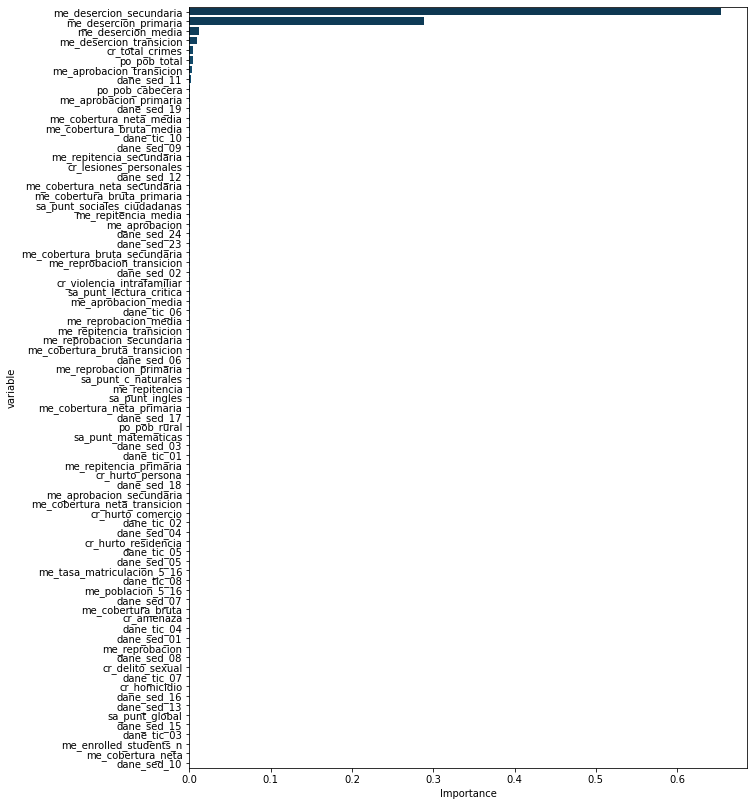

In [26]:
X_all=mun_nomiss.drop(vars_drop, axis=1)

y=mun_nomiss['desertion_perc']

# define the model
xgb_model = XGBRegressor()
# fit the model
xgb_model.fit(X_all, y)
# get importance
 
features_imp=dict(zip(X_all.columns, xgb_model.feature_importances_))
features_imp=pd.DataFrame.from_dict(features_imp, orient='index').reset_index()
features_imp.rename(columns={'index':'variable',0:'Importance'},inplace=True)
features_imp=features_imp.sort_values(by='Importance', ascending=False)
features_imp.to_clipboard(index=False,header=True)

plt.figure(figsize=(10,14))
ax = sns.barplot(x="Importance", y="variable", data=features_imp,palette="PuBu_r")


### Ajuste del modelo

In [116]:
feature_cols = ['me_desercion_secundaria','me_desercion_primaria','me_desercion_media','me_desercion_transicion','po_pob_total','cr_total_crimes']

X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

xgb1 = XGBRegressor()
parameters = {'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 5,n_jobs = -1,verbose=False)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9850067973303609
{'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1}


MAE train: 0.07243547185329456
MAE test: 0.15899776266217233
RMSE train: 0.09415071664369376
RMSE test: 0.2638882198314687
R-Squared train: 0.9971401256032681
R-Squared test: 0.9714036755229484


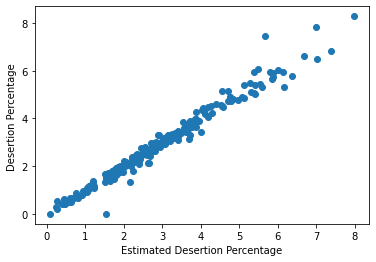

In [120]:
xbg_model = XGBRegressor(random_state=12345,learning_rate=0.2,max_depth=3,min_child_weight=1)
xbg_model = xbg_model.fit(X_train,y_train)
y_pred_train = xbg_model.predict(X_train)
y_pred_test = xbg_model.predict(X_test)

MAPE_train=np.mean(np.abs((y_train - y_pred_train) / (y_train))) * 100
MAPE_test=np.mean(np.abs((y_test - y_pred_test) / (y_test))) * 100
MAE_train=metrics.mean_absolute_error(y_train, y_pred_train)
MAE_test=metrics.mean_absolute_error(y_test, y_pred_test)
RMSE_train=np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
RMSE_test=np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
R2_train=metrics.r2_score(y_train, y_pred_train)
R2_test=metrics.r2_score(y_test, y_pred_test)

#print("MAPE train:",MAPE_train)
#print("MAPE test:",MAPE_test)
print("MAE train:",MAE_train)
print("MAE test:",MAE_test)
print("RMSE train:",RMSE_train)
print("RMSE test:",RMSE_test)
print("R-Squared train:",R2_train)
print("R-Squared test:",R2_test)

plt.scatter(y_pred_test, y_test)
plt.xlabel("Estimated Desertion Percentage")
plt.ylabel("Desertion Percentage ")
plt.show()
